# Displacement and Strain Analysis
This notebook uses the position of mitochondria in C. elegans TRNs and calculates the displacement and strain induced in those TRNs by mechanical stimulus.

## Todos:
- Fit individual actuation events and plot resulting width of distribution
- Goodness-of-fit tests for fitting displacements
- Statistical comparison of strain values
- Calculate distance of TRN from actuator

## Setup
### Choose worm strain and neuron

In [1]:
worm_strains = ['NM3573', 'GN885', 'GN886', 'GN887', 'GN906']#, 'N2']
neurons = ['ALM']

allele_dict = {'NM3573': 'control',
               'GN885': 'him-4(e1267)',
               'GN886': 'mec-1(e1066)',
               'GN887': 'mec-1(e1738)',
               'GN906': 'mec-5(u444)',
               'N2': 'wild-type'}

### Experimental parameters

In [2]:
pixel_to_micron = 0.275
analyzed_data_dir = '/Users/adam/Documents/SenseOfTouchResearch/SSN_AnalyzedData/'
raw_data_dir = '/Users/adam/Documents/SenseOfTouchResearch/SSN_data/'
fig_save_dir = analyzed_data_dir + 'PreliminaryPlots/'

### Import packages

In [3]:
import yaml
import time
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.spatial import distance
from scipy import stats
from scipy.optimize import curve_fit
from statsmodels.stats import multicomp 
import pims
from nd2reader import ND2Reader 
import math
import warnings
import glob
import numpy as np
import typing
import pathlib
import seaborn as sns
import line_profiler
import dabest

start = time.time()
for current_worm_strain in worm_strains:
    for current_neuron in neurons:
        current_strain_TRN = current_worm_strain + '_' + current_neuron
        fig_path = pathlib.Path(fig_save_dir + current_strain_TRN)
        if fig_path.exists() is False:
            fig_path.mkdir()

### Settings for plot aesthetics

In [4]:
sns.set(font_scale=1.2)
sns.set_style('ticks')
sns.set_palette('colorblind')

## Load data
### Start with metadata

In [5]:
analyzed_trials = glob.iglob(analyzed_data_dir + '*')
all_metadata = []
for trial in analyzed_trials:
    try:
        with open(trial + '/metadata.yaml') as metadata_file:
            all_metadata.append(yaml.safe_load(metadata_file))
    except FileNotFoundError:
        pass
    except NotADirectoryError:
        pass

metadata_df = pd.DataFrame(all_metadata)

#### Select only the trials that have been successfully processed
Also get a count of the number of trials for each genotype

In [6]:
trials_for_analysis = metadata_df.loc[(metadata_df['analysis_status'] == 'Strain calculated') &
                                                   (metadata_df['actuator_center'].notnull()) &
                                                   (metadata_df['neuron'].isin(neurons)) &
                                                   (metadata_df['worm_strain'].isin(worm_strains))].copy()

worm_strain_categories = pd.api.types.CategoricalDtype(categories=worm_strains, ordered=True)
trials_for_analysis['worm_strain'] = trials_for_analysis['worm_strain'].astype(worm_strain_categories)
trials_for_analysis.sort_values('worm_strain', inplace=True)
# display(trials_for_analysis)

n_trials_dict = trials_for_analysis['worm_strain'].value_counts().to_dict()

In [7]:
print(n_trials_dict)

{'GN906': 17, 'GN887': 16, 'GN885': 16, 'NM3573': 15, 'GN886': 14}


### Load mitochondria position data

In [8]:
list_of_linked_mito_dfs = []
linked_mitos_df = pd.DataFrame()
for index, row in trials_for_analysis.iterrows():
    experiment_id = row['Experiment_id']
    linked_mitos_file = analyzed_data_dir + experiment_id + '/mito_locations.yaml'
    with open(linked_mitos_file, 'r') as yamlfile:
        linked_mitos_dict = yaml.safe_load(yamlfile)

    parsed_dict = {k: linked_mitos_dict[k] for k in (
        'frame', 'particle', 'pressure', 'x', 'y', 'z')}
    parsed_df = pd.DataFrame(parsed_dict)
    parsed_df['Experiment_id'] = experiment_id
    parsed_df['worm_strain'] = row['worm_strain']
    parsed_df['genotype'] = allele_dict[row['worm_strain']]
    list_of_linked_mito_dfs.append(parsed_df)

linked_mitos_df = pd.concat(list_of_linked_mito_dfs)
linked_mitos_df['worm_strain'] = linked_mitos_df['worm_strain'].astype(worm_strain_categories)

In [9]:
linked_mitos_df.groupby(['worm_strain', 'particle']).count()

frame  pressure      x      y      z  Experiment_id  \
worm_strain particle                                                        
NM3573      0           NaN       NaN    NaN    NaN    NaN            NaN   
            1         102.0     102.0  102.0  102.0  102.0          102.0   
            2          81.0      81.0   81.0   81.0   81.0           81.0   
            3          81.0      81.0   81.0   81.0   81.0           81.0   
            4         111.0     111.0  111.0  111.0  111.0          111.0   
            5         107.0     107.0  107.0  107.0  107.0          107.0   
            6          87.0      87.0   87.0   87.0   87.0           87.0   
            7         112.0     112.0  112.0  112.0  112.0          112.0   
            8          80.0      80.0   80.0   80.0   80.0           80.0   
            9          94.0      94.0   94.0   94.0   94.0           94.0   
            10         75.0      75.0   75.0   75.0   75.0           75.0   
            11         72.0      72.0   72.0   72.0   72.0           72.0   
            12          7.0       7.0    7.0    7.0    7.0            7.0   
            13         32.0      32.0   32.0   32.0   32.0           32.0   
            14         27.0      27.0   27.0   27.0   27.0           27.0   
            15         27.0      27.0   27.0   27.0   27.0           27.0   
            16         34.0      34.0   34.0   34.0   34.0           34.0   
            17          7.0       7.0    7.0    7.0    7.0            7.0   
            18         29.0      29.0   29.0   29.0   29.0           29.0   
            19          NaN       NaN    NaN    NaN    NaN            NaN   
            21          NaN       NaN    NaN    NaN    NaN            NaN   
            22          7.0       7.0    7.0    7.0    7.0            7.0   
            23          7.0       7.0    7.0    7.0    7.0            7.0   
            26          NaN       NaN    NaN    NaN    NaN            NaN   
            30          NaN       NaN    NaN    NaN    NaN            NaN   
GN885       0           NaN       NaN    NaN    NaN    NaN            NaN   
            1          82.0      82.0   82.0   82.0   82.0           82.0   
            2         101.0     101.0  101.0  101.0  101.0          101.0   
            3          93.0      93.0   93.0   93.0   93.0           93.0   
            4         116.0     116.0  116.0  116.0  116.0          116.0   
...                     ...       ...    ...    ...    ...            ...   
GN887       21          NaN       NaN    NaN    NaN    NaN            NaN   
            22          NaN       NaN    NaN    NaN    NaN            NaN   
            23          NaN       NaN    NaN    NaN    NaN            NaN   
            26          NaN       NaN    NaN    NaN    NaN            NaN   
            30          7.0       7.0    7.0    7.0    7.0            7.0   
GN906       0           7.0       7.0    7.0    7.0    7.0            7.0   
            1          66.0      66.0   66.0   66.0   66.0           66.0   
            2          72.0      72.0   72.0   72.0   72.0           72.0   
            3          76.0      76.0   76.0   76.0   76.0           76.0   
            4          71.0      71.0   71.0   71.0   71.0           71.0   
            5          93.0      93.0   93.0   93.0   93.0           93.0   
            6          78.0      78.0   78.0   78.0   78.0           78.0   
            7          61.0      61.0   61.0   61.0   61.0           61.0   
            8          70.0      70.0   70.0   70.0   70.0           70.0   
            9          43.0      43.0   43.0   43.0   43.0           43.0   
            10         22.0      22.0   22.0   22.0   22.0           22.0   
            11         10.0      10.0   10.0   10.0   10.0           10.0   
            12         21.0      21.0   21.0   21.0   21.0           21.0   
            13          NaN       NaN    NaN    NaN    NaN            NaN   
            14    

## Find displacements from position data 
### Correct y value for actuator location and worm head direction
A y coordinate of 0 is the center of the actuator, and negative values correspond to the anterior side of the worm

In [10]:
def correct_y_value(row):
    current_metadata = trials_for_analysis.loc[trials_for_analysis['Experiment_id'] == row['Experiment_id']]

    if current_metadata['head_orientation'].str.contains('Headfirst').all():
        worm_head_direction = -1
    elif current_metadata['head_orientation'].str.contains('Tailfirst').all():
        worm_head_direction = 1
    else:
        raise ValueError

    yval_middle_of_actuator = current_metadata['actuator_center'].values[0][1]
    
    return worm_head_direction * (row['y'] - yval_middle_of_actuator)

linked_mitos_df['y'] = linked_mitos_df.apply(correct_y_value, axis=1)
# linked_mitos_df['y_pixel'] = linked_mitos_df['y']

### Convert coordinates from pixels to microns

In [11]:
for coord in ['x', 'y', 'z']:
    linked_mitos_df[coord] = linked_mitos_df[coord] * pixel_to_micron

### Find rest locations
The rest location is the "undeformed" reference location for a particular mitochondrion. This is not truly undeformed since the worm is compressed in the trap, but it corresponds to the reference configuration for calculating strain

In [12]:
def find_rest_locations(row, dimension):
    if row['pressure'] == 0:
        rest_dist = row[dimension]
    elif row['pressure'] != 0:
        rest_dist = linked_mitos_df.loc[
            (linked_mitos_df['Experiment_id'] == row['Experiment_id']) &
            (linked_mitos_df['frame'] == row['frame'] - 1) &
            (linked_mitos_df['particle'] == row['particle'])][dimension].values[0]
    
    return rest_dist

for dimension in ['x', 'y', 'z']:
    linked_mitos_df[dimension + '_rest'] = linked_mitos_df.apply(
        find_rest_locations, dimension=dimension, axis=1)

### Calculate displacements
The displacement of a mitochondrion is the distance between its current location and its rest location.

In [13]:
def calc_distance(row, dimension):
    return distance.euclidean([row[dim] for dim in list(dimension)],
                              [row[dim + '_rest'] for dim in list(dimension)])

for dimension in ['x', 'y', 'z', 'xz', 'xyz']:
    linked_mitos_df[dimension + '_dist'] = linked_mitos_df.apply(
        calc_distance, dimension=dimension, axis=1)

def calc_displacement(row, dimension):
    return row[dimension] - row[dimension + '_rest']

for dimension in ['x', 'y', 'z']:
    linked_mitos_df[dimension + '_disp'] = linked_mitos_df.apply(
        calc_displacement, dimension=dimension, axis=1)

In [134]:
trials_for_analysis[['actuator_center', 'vulva_orientation']]

,actuator_center,vulva_orientation
47,"[223.0, 479.0]",East
68,"[405.0, 526.0]",West
67,"[214.5, 536.5]",East
66,"[370.5, 529.5]",West
65,"[224.5, 520.0]",East
62,"[224.0, 517.5]",East
61,"[243.5, 559.5]",East
63,"[376.5, 542.0]",West
59,"[359.5, 505.5]",West
58,"[206.5, 469.5]",East


### Fit gaussian to displacement profile to interpolate max displacement 

In [14]:
def transformed_normal(x, loc, scale, mag):
    return mag * stats.norm.pdf(x, loc, scale)

def calc_max_dist_from_norm_fit(row):
    max_dist = transformed_normal(row['max_dist_location'],
                                  row['max_dist_location'],
                                  row['normal_scale_param'],
                                  row['normal_magnitude_param'])
    return max_dist

individual_fit_param_list = []
for index, trial in trials_for_analysis.iterrows():
#     print(trial)
    frames = linked_mitos_df.loc[
        (linked_mitos_df['Experiment_id'] == trial['Experiment_id']) &
        (linked_mitos_df['pressure'] == 300)]['frame'].unique()
    for frame in frames:
#         print(frame)
        this_actuation_event = linked_mitos_df.loc[
            (linked_mitos_df['Experiment_id'] == trial['Experiment_id']) &
            (linked_mitos_df['frame'] == frame)]
#         print(this_actuation_event)
        popt_norm, pcov_norm = curve_fit(
            transformed_normal,
            this_actuation_event['y'],
            this_actuation_event['x_dist'],
            p0=(0, 20, 400),
            maxfev=1000000)#,
    #         bounds=((-5, 1, 50),
    #                 (5, 100, 500)))
        perr = np.sqrt(np.diag(pcov_norm))
        fit_param_dict = {
            'Experiment_id': trial['Experiment_id'],
            'worm_strain': trial['worm_strain'],
            'genotype': allele_dict[trial['worm_strain']], 
            'frame': frame,
            'max_dist_location': popt_norm[0],
            'normal_scale_param': popt_norm[1],
            'fwhm_fit': popt_norm[1] * 2 * np.sqrt(2 * np.log(2)),
            'normal_magnitude_param': popt_norm[2],
            'scale_uncertainty': perr[1]
        }
        individual_fit_param_list.append(fit_param_dict)
individual_fit_param_df = pd.DataFrame(individual_fit_param_list)
individual_fit_param_df['max_dist'] = individual_fit_param_df.apply(calc_max_dist_from_norm_fit, axis=1)

F_onewayResult(statistic=7.183826447523013, pvalue=1.6078532153545768e-05)
       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower    upper  reject
-----------------------------------------------------------------
     control him-4(e1267)  17.2645  0.001   7.2154 27.3137   True
     control mec-1(e1066)   1.4747    0.9   -9.172 12.1213  False
     control mec-1(e1738)   8.2585 0.1425  -1.5286 18.0456  False
     control  mec-5(u444)  11.3457 0.0334   0.5742 22.1172   True
him-4(e1267) mec-1(e1066) -15.7899  0.001 -26.4365 -5.1432   True
him-4(e1267) mec-1(e1738)   -9.006 0.0875 -18.7932  0.7811  False
him-4(e1267)  mec-5(u444)  -5.9188   0.55 -16.6904  4.8527  False
mec-1(e1066) mec-1(e1738)   6.7838 0.3819  -3.6158 17.1835  False
mec-1(e1066)  mec-5(u444)    9.871 0.1208    -1.46  21.202  False
mec-1(e1738)  mec-5(u444)   3.0872    0.9  -7.4403 13.6147  False
-----------------------------------------------------------------


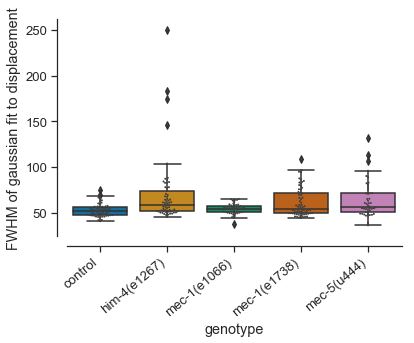

In [15]:
# individual_fit_param_df_more_than_2um = individual_fit_param_df.loc[
#     individual_fit_param_df['max_dist'] > 2]

ax = sns.boxplot(x='genotype', y='fwhm_fit', data=individual_fit_param_df)
ax = sns.swarmplot(x='genotype', y='fwhm_fit', color=".25", size=2, data=individual_fit_param_df)
ax.set_ylabel('FWHM of gaussian fit to displacement')
labels = ax.get_xticklabels()
sns.despine(offset=10)
ax.set_xticklabels(labels, rotation=40, ha='right')

deformation_extent = []
for this_worm_strain in worm_strains:
    deformation_extent.append(individual_fit_param_df.loc[
        individual_fit_param_df['worm_strain'] == this_worm_strain]['fwhm_fit'])
# for this_worm_strain in worm_strains:
#     deformation_extent.append(individual_fit_param_df_more_than_2um.loc[
#         individual_fit_param_df_more_than_2um['worm_strain'] == this_worm_strain]['fwhm_fit'])
    
    
print(stats.f_oneway(*deformation_extent))

mc = multicomp.MultiComparison(individual_fit_param_df['fwhm_fit'], 
                               individual_fit_param_df['genotype'],
                               group_order=[allele_dict[strain] for strain in worm_strains])
print(mc.tukeyhsd())


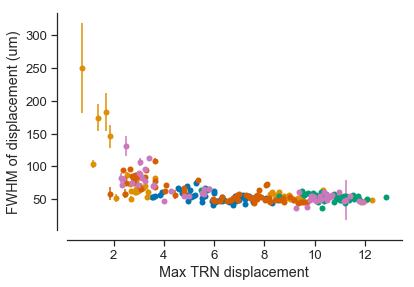

In [16]:
fig, ax = plt.subplots()

the_count = 0
for worm_strain in worm_strains:
    data_from_current_genotype = individual_fit_param_df.loc[
        individual_fit_param_df['worm_strain'] == worm_strain]
    plt.errorbar(data_from_current_genotype['max_dist'],
                 2 * np.sqrt(2 * np.log(2)) * data_from_current_genotype['normal_scale_param'],
                 yerr=data_from_current_genotype['scale_uncertainty'],
                 marker='o', linestyle='none', markeredgecolor='none',
                 color=sns.color_palette()[the_count])
    the_count += 1
ax.set_ylabel('FWHM of displacement (um)')
ax.set_xlabel('Max TRN displacement')
sns.despine(offset=10)

In [17]:
# def transformed_normal(x, loc, scale, mag):
#     return mag * stats.norm.pdf(x, loc, scale)

# def calc_max_dist_from_norm_fit(row):
#     max_dist = transformed_normal(row['max_dist_location'],
#                                   row['max_dist_location'],
#                                   row['normal_scale_param'],
#                                   row['normal_magnitude_param'])
#     return max_dist

fit_param_list = []
for index, trial in trials_for_analysis.iterrows():
#     print(trial)
    actuation_events = linked_mitos_df.loc[
        (linked_mitos_df['Experiment_id'] == trial['Experiment_id']) &
        (linked_mitos_df['pressure'] == 300)]
    popt_norm, pcov_norm = curve_fit(
        transformed_normal,
        actuation_events['y'],
        actuation_events['x_dist'],
        p0=(0, 20, 400),
        maxfev=1000000)#,
#         bounds=((-5, 1, 50),
#                 (5, 100, 500)))
    fit_param_dict = {
        'Experiment_id': trial['Experiment_id'],
        'worm_strain': trial['worm_strain'],
        'genotype': allele_dict[trial['worm_strain']], 
        'max_dist_location': popt_norm[0],
        'normal_scale_param': popt_norm[1],
        'normal_magnitude_param': popt_norm[2]
    }
    fit_param_list.append(fit_param_dict)
fit_param_df = pd.DataFrame(fit_param_list)
fit_param_df['max_dist'] = fit_param_df.apply(calc_max_dist_from_norm_fit, axis=1)

### Correct y values using interpolated location of actuator center
By fitting a gaussian to the displacement profile, we get a value for how far the peak of the gaussian needed to be shifted. This is our best estimate of the center position of the actuator, since that is where the actuation is greatest. As a result, we correct the longitudinal coordinate again.

In [18]:
def correct_y_using_fit(row, dimension):
    interpolated_center = fit_param_df.loc[
        fit_param_df['Experiment_id'] == row['Experiment_id']][
        'max_dist_location'].values[0]
    return row[dimension] - interpolated_center

linked_mitos_df['y'] = linked_mitos_df.apply(correct_y_using_fit, dimension='y', axis=1)
linked_mitos_df['y_rest'] = linked_mitos_df.apply(correct_y_using_fit, dimension='y_rest', axis=1)

## Plots of mitochondria locations and displacements

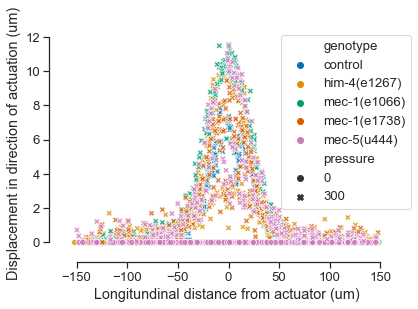

In [19]:
fig, ax = plt.subplots()
ax = sns.scatterplot(x='y', y='x_dist', data=linked_mitos_df, hue='genotype', style='pressure', alpha=0.8)
sns.despine(ax=ax, offset=10, trim=True)
ax.set_xlabel('Longitundinal distance from actuator (um)')
ax.set_ylabel('Displacement in direction of actuation (um)')
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)
fig.savefig(fig_save_dir + 'x_disp_vs_position', bbox_inches='tight')

In [20]:
# fig, ax = plt.subplots()
# ax = sns.scatterplot(x='y', y='y_disp', data=linked_mitos_df, hue='genotype', style='pressure')
# sns.despine(ax=ax, offset=10)
# ax.set_xlabel('Longitundinal distance from actuator (um)')
# ax.set_ylabel('Longitudinal displacement of mitochondria (um)')
# plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.);

In [21]:
# ax = sns.swarmplot(x='genotype', y='normal_scale_param', data=fit_param_df)
# ax.set_ylabel('SD of gaussian fit to displacement');

In [22]:
# fig, ax = plt.subplots()
# # g = sns.jointplot(x='y', y='y_disp', #scatter_kws={'alpha':0.3},
# #                data=linked_mitos_df.loc[(linked_mitos_df['pressure'] == 300) &
# #                                          (linked_mitos_df['worm_strain'] == 'NM3573')])
# # g = g.plot(sns.scatterplot, sns.distplot)
# # g = sns.JointGrid(x="total_bill", y="tip", data=tips)

# for this_strain in worm_strains:
#     sns.regplot(x='y', y='y_disp', x_ci=None, ci=None, marker='x', scatter_kws={'alpha':0.3},
#                 data=linked_mitos_df.loc[(linked_mitos_df['pressure'] == 300) &
#                                          (linked_mitos_df['worm_strain'] == this_strain)])
# sns.despine(offset=10, trim=True)
# # plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.);



In [23]:
# g = sns.jointplot(y='y_disp', x='y',
#                  data=linked_mitos_df.loc[(linked_mitos_df['pressure'] == 300) &
#                                           (linked_mitos_df['worm_strain'] == 'NM3573')])

# # sns.distplot

In [24]:
# fit_param_df.shape

### Interpolated max displacement
This shouldn't vary between genotypes, since the actuator is applying the same displacement regardless of genotype.

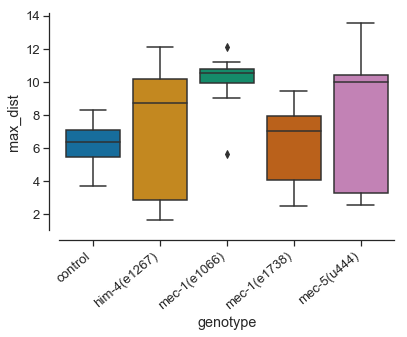

In [25]:
ax = sns.boxplot(x='genotype', y='max_dist', data=fit_param_df)
labels = ax.get_xticklabels()
sns.despine(offset=10)
ax.set_xticklabels(labels, rotation=40, ha='right');

### Plot showing distribution of mitochondria along TRNs


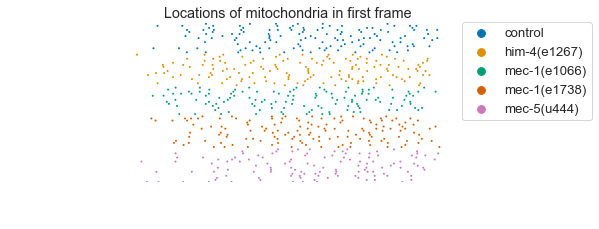

In [26]:
ax = sns.stripplot(x='y', y='Experiment_id', hue='genotype', dodge=True, size=2,
              data=linked_mitos_df[linked_mitos_df['frame'] == 0])
ax.legend(bbox_to_anchor=(1, 1.05))
ax.set_aspect(2)
ax.axis('off')
ax.set_title('Locations of mitochondria in first frame');

### Plot showing how many mitochondria were tracked in each trial

/Users/adam/anaconda3/envs/spinningDiskAnalysis/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Minimum:


genotype
control         5
him-4(e1267)    6
mec-1(e1066)    6
mec-1(e1738)    6
mec-5(u444)     5
Name: particle, dtype: int64

Mean:


genotype
control         8.866667
him-4(e1267)    9.062500
mec-1(e1066)    8.857143
mec-1(e1738)    8.875000
mec-5(u444)     7.176471
Name: particle, dtype: float64

SEM:


genotype
control         0.631451
him-4(e1267)    0.503891
mec-1(e1066)    0.512022
mec-1(e1738)    0.515388
mec-5(u444)     0.479240
Name: particle, dtype: float64

Maximum:


genotype
control         15
him-4(e1267)    13
mec-1(e1066)    13
mec-1(e1738)    15
mec-5(u444)     12
Name: particle, dtype: int64

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,control,him-4(e1267),15,16,mean difference,False,0.195833,95,-1.475000,1.645833,0.810280,-0.242410,0.808979,-0.243961,0.630352,107.5
1,control,mec-1(e1066),15,14,mean difference,False,-0.009524,95,-1.742857,1.452381,0.990742,0.011715,0.990818,0.011615,1.000000,104.5
2,control,mec-1(e1738),15,16,mean difference,False,0.008333,95,-1.604167,1.516667,0.991916,-0.010224,0.991867,-0.010282,0.951574,118.0
3,control,mec-5(u444),15,17,mean difference,False,-1.690196,95,-3.298039,-0.298039,0.042260,2.132154,0.038780,2.161291,0.048452,179.5


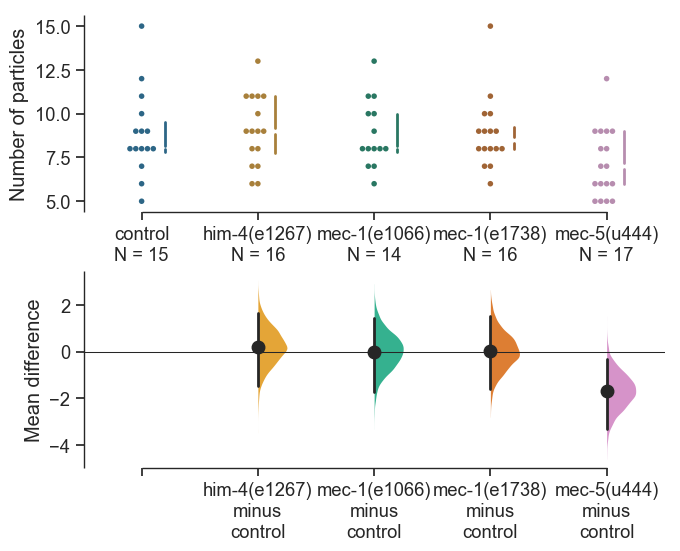

In [27]:
particle_count_df = linked_mitos_df.loc[
    linked_mitos_df['frame'] == 0].groupby(
    ['Experiment_id', 'genotype'], as_index=False).count()

num_mitos_in_trial = dabest.load(particle_count_df, x='genotype', y='particle',
                            idx=('control', 'him-4(e1267)', 'mec-1(e1066)','mec-1(e1738)', 'mec-5(u444)'))
fig = num_mitos_in_trial.mean_diff.plot(
    raw_marker_size=4, group_summaries='median_quartiles', #contrast_ylim=(-0.75,0.1),
    custom_palette=sns.color_palette())

fig.axes[0].set_ylabel('Number of particles')
fig.savefig(fig_save_dir + 'mitos_per_trial_by_genotype.eps')
print('Minimum:')
display(particle_count_df.groupby('genotype').min()['particle'])
print('Mean:')
display(particle_count_df.groupby('genotype').mean()['particle'])
print('SEM:')
display(particle_count_df.groupby('genotype').sem()['particle'])
print('Maximum:')
display(particle_count_df.groupby('genotype').max()['particle'])
num_mitos_in_trial.mean_diff.statistical_tests

## Create dataframe with data for pairs of adjacent mitochondria
- experiment id
- pair id
- particle ids
- frame number
- actuation pressure
- worm strain name
- genotype
- current distance between pairs
- stretch
- strain
### Match adjacent mitochondria into pairs

In [28]:
def make_pairs_df(df_with_linked_mitos):
    mito_pair_df_list = []
    df_with_linked_mitos.sort_values(['worm_strain', 'Experiment_id', 'frame', 'y'], inplace=True)
    for trial in df_with_linked_mitos['Experiment_id'].unique():
        for frame in df_with_linked_mitos.loc[df_with_linked_mitos['Experiment_id'] == trial]['frame'].unique():
            pair_count = 0
            # create iterrator to go through the particles of only this frame
            iterrator = df_with_linked_mitos.loc[
                    (df_with_linked_mitos['Experiment_id'] == trial) &
                    (df_with_linked_mitos['frame'] == frame)].iterrows() 
            # skip the first one, since we want to make pairs
            previous_index, previous_row = next(iterrator)
            for index, row in iterrator:
                this_dist = distance.euclidean(previous_row[['x', 'y', 'z']], row[['x', 'y', 'z']])
                rest_dist = distance.euclidean(
                    previous_row[['x_rest', 'y_rest', 'z_rest']], row[['x_rest', 'y_rest', 'z_rest']])
                this_mito_pair_dict = {
                    'Experiment_id': row['Experiment_id'],
                    'frame': row['frame'],
                    'particle_1': previous_row['particle'],
                    'particle_1_yval': previous_row['y'],
                    'particle_2': row['particle'],
                    'particle_2_yval': row['y'],
                    'pair_id': pair_count,
                    'pressure': row['pressure'],
                    'max_actuation': fit_param_df.loc[
                        (fit_param_df['Experiment_id'] == row['Experiment_id'])]['max_dist'].values[0],
                    'worm_strain': row['worm_strain'],
                    'genotype': row['genotype'],
                    'distance': this_dist,
                    'rest_dist': rest_dist,
                    'timestamp': trials_for_analysis.loc[
                        trials_for_analysis['Experiment_id'] == row['Experiment_id']]['timestamp'].values[0]}
                for dim in ['x', 'y', 'z']:
                    this_mito_pair_dict[dim + '_dist'] = distance.euclidean(previous_row[dim], row[dim])
                    this_mito_pair_dict[dim + '_rest_dist'] = distance.euclidean(
                        previous_row[dim + '_rest'],
                        row[dim + '_rest'])
                mito_pair_df_list.append(this_mito_pair_dict)
                pair_count += 1
                previous_row = row

    df_with_mito_pairs = pd.DataFrame(mito_pair_df_list)
    df_with_mito_pairs['worm_strain'] = df_with_mito_pairs['worm_strain'].astype(worm_strain_categories)
    df_with_mito_pairs.sort_values('worm_strain', inplace=True)

    return df_with_mito_pairs

mito_pair_df = make_pairs_df(linked_mitos_df)

/Users/adam/anaconda3/envs/spinningDiskAnalysis/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


Min:


genotype
control         5.003019
him-4(e1267)    4.951283
mec-1(e1066)    4.690472
mec-1(e1738)    5.092111
mec-5(u444)     5.418538
Name: distance, dtype: float64

Mean:


genotype
control         25.959381
him-4(e1267)    27.700374
mec-1(e1066)    27.199843
mec-1(e1738)    26.648748
mec-5(u444)     30.930987
Name: distance, dtype: float64

Standard Error of the Mean:


genotype
control         0.411583
him-4(e1267)    0.406829
mec-1(e1066)    0.510842
mec-1(e1738)    0.388967
mec-5(u444)     0.632105
Name: distance, dtype: float64

Max:


genotype
control         64.380281
him-4(e1267)    76.101376
mec-1(e1066)    67.312651
mec-1(e1738)    64.123921
mec-5(u444)     84.800146
Name: distance, dtype: float64

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,control,him-4(e1267),1046,1090,mean difference,False,1.740992,95,0.640747,2.864595,2.657172e-03,-3.008382,2.661993e-03,-3.007825,5.258012e-03,530303.0
1,control,mec-1(e1066),1046,840,mean difference,False,1.240462,95,-0.069686,2.511456,5.880754e-02,-1.890897,5.590889e-02,-1.912927,1.747064e-01,423366.0
2,control,mec-1(e1738),1046,1137,mean difference,False,0.689366,95,-0.452879,1.802407,2.236165e-01,-1.217317,2.233295e-01,-1.218069,1.959536e-01,575625.0
3,control,mec-5(u444),1046,618,mean difference,False,4.971606,95,3.455586,6.511115,6.681301e-11,-6.591086,8.672608e-12,-6.876161,5.570799e-09,268008.0


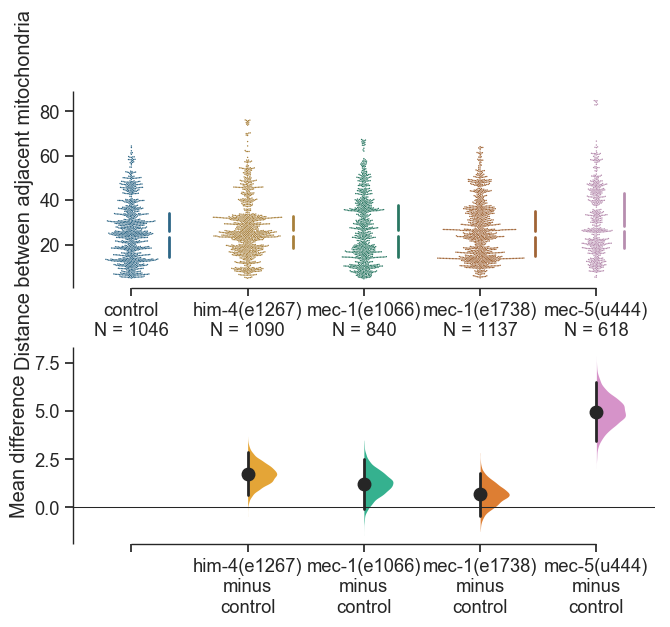

In [29]:
mito_pair_df.loc[(mito_pair_df['worm_strain'] == 'NM3573') &
                 (mito_pair_df['pressure'] == 0)]['distance'].mean() # create histogram of mitochondria distances by genotype?

# particle_count_df = linked_mitos_df.loc[
#     linked_mitos_df['frame'] == 0].groupby(
#     ['Experiment_id', 'genotype'], as_index=False).count()

mito_distances = dabest.load(mito_pair_df, x='genotype', y='distance',
                            idx=('control', 'him-4(e1267)', 'mec-1(e1066)','mec-1(e1738)', 'mec-5(u444)'))
fig = mito_distances.mean_diff.plot(
    raw_marker_size=1, group_summaries='median_quartiles',
    custom_palette=sns.color_palette())

fig.axes[0].set_ylabel('Distance between adjacent mitochondria')
fig.savefig(fig_save_dir + 'mito_distances.eps')
print('Min:')
display(mito_pair_df.groupby('genotype').min()['distance'])
print('Mean:')
display(mito_pair_df.groupby('genotype').mean()['distance'])
print('Standard Error of the Mean:')
display(mito_pair_df.groupby('genotype').sem()['distance'])
print('Max:')
display(mito_pair_df.groupby('genotype').max()['distance'])
mito_distances.mean_diff.statistical_tests

### Calculate stretch and strain

In [30]:
def calc_stretch(row):
    return row['distance'] - row['rest_dist']

def calc_strain(row):
    return row['stretch'] / row['rest_dist']

def calc_green_strain(row):
    return (row['stretch']**2 - 1) / 2

mito_pair_df['stretch'] = mito_pair_df.apply(calc_stretch, axis=1)
mito_pair_df['strain'] = mito_pair_df.apply(calc_strain, axis=1)
mito_pair_df['green_strain'] = mito_pair_df.apply(calc_strain, axis=1)

### Estimate uncertainty by calculating strain in frames with no actuation
In a perfect measurement, the distance between mitos should be the same in all stacks where the actuation is off, since there is no stimulus. In reality, the worm in the device can move on its own, so this is not true. To estimate the uncertainty of our strain measurement, we use the most recent stack where the actuation was off as the rest condition and calculate strain.

In [31]:
mito_pairs_pressure_off = make_pairs_df(linked_mitos_df.loc[linked_mitos_df['pressure'] == 0].copy())

for index, row in mito_pairs_pressure_off.iterrows():
    if row['frame'] != 0:
        mito_pairs_pressure_off.loc[index, 'rest_dist'] = mito_pairs_pressure_off.loc[
            (mito_pairs_pressure_off['Experiment_id'] == row['Experiment_id']) &
            (mito_pairs_pressure_off['frame'] == row['frame'] - 2) &
            (mito_pairs_pressure_off['pair_id'] == row['pair_id'])]['distance'].values[0]
        for dim in ['x', 'y', 'z']:
            mito_pairs_pressure_off.loc[index, (dim + '_rest_dist')] = mito_pairs_pressure_off.loc[
                (mito_pairs_pressure_off['Experiment_id'] == row['Experiment_id']) &
                (mito_pairs_pressure_off['frame'] == row['frame'] - 2) &
                (mito_pairs_pressure_off['pair_id'] == row['pair_id'])][dim + '_dist'].values[0]

mito_pairs_pressure_off['stretch'] = mito_pairs_pressure_off.apply(calc_stretch, axis=1)
mito_pairs_pressure_off['strain'] = mito_pairs_pressure_off.apply(calc_strain, axis=1)

### Get spatial distribution of strain

In [32]:
spatial_strain_avg_list = []
for index, row in mito_pair_df.iterrows():
    y1_pixel = math.ceil(row['particle_1_yval'] / pixel_to_micron)
    y2_pixel = math.floor(row['particle_2_yval'] / pixel_to_micron)
    for y_coord in range(y1_pixel, y2_pixel):
        new_row_dict = {
            'Experiment_id': row['Experiment_id'],
            'frame': row['frame'],
            'pair_id': row['pair_id'],
            'pressure': row['pressure'],
            'max_actuation': row['max_actuation'],
            'worm_strain': row['worm_strain'],
            'genotype': row['genotype'],
            'stretch': row['stretch'],
            'strain': row['strain'],
            'green_strain': row['green_strain'],
            'y_coord': y_coord,
            'y': y_coord * pixel_to_micron}  # Add max_dist for plotting all trials color-coded by max_dist
        spatial_strain_avg_list.append(new_row_dict)

spatial_strain_df = pd.DataFrame(spatial_strain_avg_list)
spatial_strain_df['worm_strain'] = spatial_strain_df['worm_strain'].astype(worm_strain_categories)
spatial_strain_df.sort_values('worm_strain', inplace=True)

### Fit strain profile using midpoints for approximation
This method can only calculate the average strain for a given segment, but we can fit individual strain profiles using the midpoint of the interval to get a better approximation of the extent of strain in each trial.

#### Tried this, but it overfits the data

In [33]:
# # find midpoints
# mito_pair_df['midpoint'] = (mito_pair_df['particle_1_yval'] + mito_pair_df['particle_2_yval']) / 2

# # fit midpoints of each trial
# def transformed_normal(x, loc, scale, mag):
#     return mag * stats.norm.pdf(x, loc, scale)

# def calc_max_dist_from_norm_fit(row):
#     max_dist = transformed_normal(row['max_strain_location'],
#                                   row['max_strain_location'],
#                                   row['normal_scale_param'],
#                                   row['normal_magnitude_param'])
#     return max_dist

# strain_fit_param_list = []
# for index, trial in trials_for_analysis.iterrows():
# #     print(trial)
#     frames = mito_pair_df.loc[
#         (mito_pair_df['Experiment_id'] == trial['Experiment_id']) &
#         (mito_pair_df['pressure'] == 300)]['frame'].unique()
#     for frame in frames:
# #         print(frame)
#         this_actuation_event = mito_pair_df.loc[
#             (mito_pair_df['Experiment_id'] == trial['Experiment_id']) &
#             (mito_pair_df['frame'] == frame)]
# #         print(this_actuation_event)
#         popt_norm, pcov_norm = curve_fit(
#             transformed_normal,
#             this_actuation_event['midpoint'],
#             this_actuation_event['strain'],
#             p0=(0, 20, 5),
#             maxfev=1000000,
#             bounds=((-50, -50, -10),
#                     (50, 50, 10)))
#         perr = np.sqrt(np.diag(pcov_norm))
#         fit_param_dict = {
#             'Experiment_id': trial['Experiment_id'],
#             'worm_strain': trial['worm_strain'],
#             'genotype': allele_dict[trial['worm_strain']], 
#             'frame': frame,
#             'max_strain_location': popt_norm[0],
#             'normal_scale_param': popt_norm[1],
#             'fwhm_fit': popt_norm[1] * 2 * np.sqrt(2 * np.log(2)),
#             'normal_magnitude_param': popt_norm[2],
#             'scale_uncertainty': perr[1]
#         }
#         strain_fit_param_list.append(fit_param_dict)
# strain_fit_param_df = pd.DataFrame(strain_fit_param_list)
# strain_fit_param_df['max_strain'] = strain_fit_param_df.apply(calc_max_dist_from_norm_fit, axis=1)

# # get data to plot fit
# experiment_ids = strain_fit_param_df['Experiment_id'].unique()
# fig, axes = plt.subplots(nrows=len(experiment_ids), figsize=(5, 5*len(experiment_ids)))
# index = 0
# for exp_id in experiment_ids:
#     for frame in strain_fit_param_df.loc[
#             strain_fit_param_df['Experiment_id']==exp_id]['frame'].unique():
#         min_y = mito_pair_df.loc[
#             (mito_pair_df['Experiment_id']==exp_id) &
#             (mito_pair_df['frame']==frame)]['particle_1_yval'].min()
#         max_y = mito_pair_df.loc[
#             (mito_pair_df['Experiment_id']==exp_id) &
#             (mito_pair_df['frame']==frame)]['particle_2_yval'].max()
#         y_coords = list(range(int(min_y), int(max_y)))
#         current_fit_df = pd.DataFrame({'y': y_coords})
#         fit_params = strain_fit_param_df.loc[(strain_fit_param_df['Experiment_id'] == exp_id) &
#                                              (strain_fit_param_df['frame'] == frame)]
#         current_fit_df['strain_fit'] = current_fit_df.apply(
#             lambda row: transformed_normal(row['y'],
#                                            fit_params['max_strain_location'],
#                                            fit_params['normal_scale_param'],
#                                            fit_params['normal_magnitude_param']), axis=1)
#         sns.lineplot(x='y', y='strain_fit', data=current_fit_df, ax=axes[index])
#         sns.scatterplot(x='midpoint', y='strain', ax=axes[index],
#                        data=mito_pair_df.loc[(mito_pair_df['Experiment_id']==exp_id) &
#                                              (mito_pair_df['frame']==frame)])
#     index += 1

## Plots of strain
### Plot strain at middle of actuator

260.6071491241455


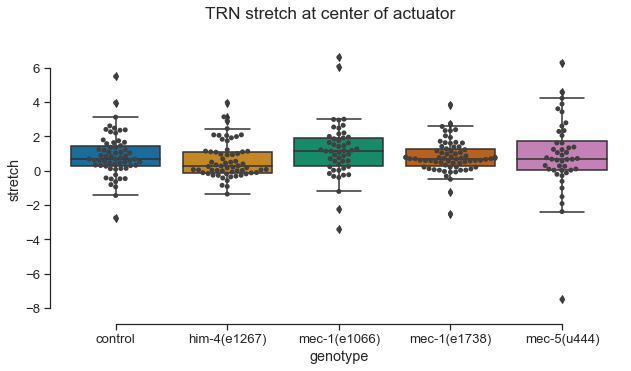

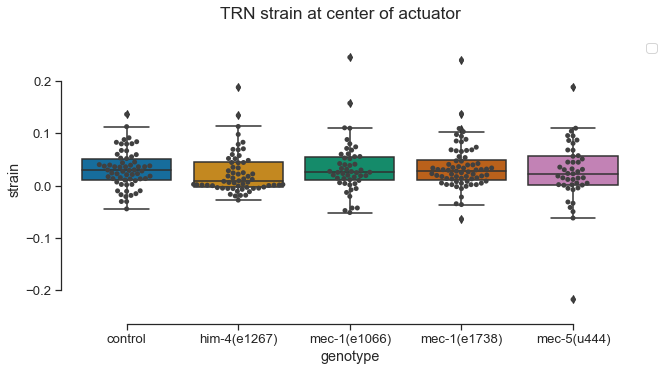

In [34]:
central_mito_pair_df = mito_pair_df.loc[
    ((mito_pair_df['particle_1_yval'] < 0) != 
     (mito_pair_df['particle_2_yval'] < 0)) &
    (mito_pair_df['pressure'] != 0)].copy()
central_mito_pair_df['worm_strain'] = central_mito_pair_df['worm_strain'].astype(worm_strain_categories)
central_mito_pair_df.sort_values('worm_strain', inplace=True)

mito_pair_adj_to_actuator_df = mito_pair_df.loc[
    ((mito_pair_df['particle_1_yval'] < 50) != 
     (mito_pair_df['particle_2_yval'] < 50)) &
    (mito_pair_df['pressure'] != 0)].copy()
central_mito_pair_df['worm_strain'] = central_mito_pair_df['worm_strain'].astype(worm_strain_categories)
central_mito_pair_df.sort_values('worm_strain', inplace=True)


n_actuations = {}
for this_strain in worm_strains:
    n_by_strain = central_mito_pair_df[central_mito_pair_df['worm_strain'] == this_strain].shape[0]
    n_actuations[allele_dict[this_strain]] = n_by_strain

fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x='genotype', y='stretch', data=central_mito_pair_df, ax=ax)
sns.swarmplot(x='genotype', y='stretch', color=".25", data=central_mito_pair_df, ax=ax)
# ax.legend(ax.artists, worm_strains)
fig.suptitle('TRN stretch at center of actuator')
sns.despine(offset=10, trim=True)
# n_trials_text = [allele_dict[strain_name] + ': ' for strain_name in worm_strains]
# text_obj = mpl.offsetbox.AnchoredText(n_trials_text, loc="upper right", frameon=False)
# ax.add_artist(text_obj)
# ax.set_xlabel(('x1', 'x2'))

fig2, ax2 = plt.subplots(figsize=(10,5))
ax2 = sns.boxplot(x='genotype', y='strain', data=central_mito_pair_df, ax=ax2)#, color='white')
# sns.stripplot(x='genotype', y='strain', hue='Experiment_id', ax=ax2, palette='tab20',
#               data=central_mito_pair_df)
sns.swarmplot(x='genotype', y='strain', color=".25", data=central_mito_pair_df, ax=ax2)
fig2.suptitle('TRN strain at center of actuator')
sns.despine(offset=10, trim=True)
# ax2.get_legend().remove()
# ax2.legend(ax2.artists, worm_strains)
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.);
fig2.savefig(fig_save_dir + 'StrainAtCenter')

print(time.time()-start)

### Descriptive statistics for control experiments

In [35]:
central_mito_pair_df.loc[
    central_mito_pair_df['genotype']=='control'][['distance', 'strain', 'stretch']].describe()

,distance,strain,stretch
count,61.000000,61.000000,61.000000
mean,34.079621,0.030880,0.884251
std,13.899549,0.036101,1.270827
min,13.112881,-0.044676,-2.742939
25%,24.736151,0.010476,0.295995
50%,31.080976,0.028940,0.689381
75%,45.265551,0.051667,1.461095
max,59.647028,0.136233,5.487197


In [36]:
standard_error = central_mito_pair_df.loc[
    central_mito_pair_df['genotype']=='control']['strain'].sem()
mean_strain = central_mito_pair_df.loc[
    central_mito_pair_df['genotype']=='control']['strain'].mean()
std_strain = central_mito_pair_df.loc[
    central_mito_pair_df['genotype']=='control']['strain'].std()
strain_95confidence_interval = stats.norm.interval(0.95, loc=mean_strain, scale=std_strain)

print('Mean strain = {:0.3f}'.format(mean_strain))
print('Standard error of the mean = {:0.4f}'.format(standard_error))
print('95% CI is', strain_95confidence_interval)

Mean strain = 0.031
Standard error of the mean = 0.0046
95% CI is (-0.03987589266751018, 0.10163624212734593)


### Descriptive statistics for all experiments

In [37]:
central_mito_pair_df[['distance', 'strain', 'stretch']].describe()

,distance,strain,stretch
count,283.000000,283.000000,283.000000
mean,34.859101,0.029967,0.862687
std,15.035441,0.045889,1.409295
min,5.057362,-0.217983,-7.490344
25%,22.589378,0.002189,0.098776
50%,32.217468,0.023109,0.698179
75%,45.769015,0.051576,1.491994
max,75.783314,0.245297,6.601428


In [38]:
for genotype in ['him-4(e1267)', 'mec-1(e1066)', 'mec-1(e1738)', 'mec-5(u444)']:
    standard_error = central_mito_pair_df.loc[
        central_mito_pair_df['genotype']==genotype]['strain'].sem()
    mean_strain = central_mito_pair_df.loc[
        central_mito_pair_df['genotype']==genotype]['strain'].mean()
    std_strain = central_mito_pair_df.loc[
        central_mito_pair_df['genotype']==genotype]['strain'].std()
    strain_95confidence_interval = stats.norm.interval(0.95, loc=mean_strain, scale=std_strain)

    print('\nFor', genotype)
    print('Mean strain = {:0.3f}'.format(mean_strain))
    print('Standard error of the mean = {:0.4f}'.format(standard_error))
    print('95% CI is', strain_95confidence_interval)



For him-4(e1267)
Mean strain = 0.024
Standard error of the mean = 0.0052
95% CI is (-0.05584899837498094, 0.10311087422553153)

For mec-1(e1066)
Mean strain = 0.034
Standard error of the mean = 0.0073
95% CI is (-0.06618695514766285, 0.13425711487892028)

For mec-1(e1738)
Mean strain = 0.035
Standard error of the mean = 0.0053
95% CI is (-0.05065951775452739, 0.12017597034834385)

For mec-5(u444)
Mean strain = 0.026
Standard error of the mean = 0.0092
95% CI is (-0.09343986671109769, 0.14454448509758747)


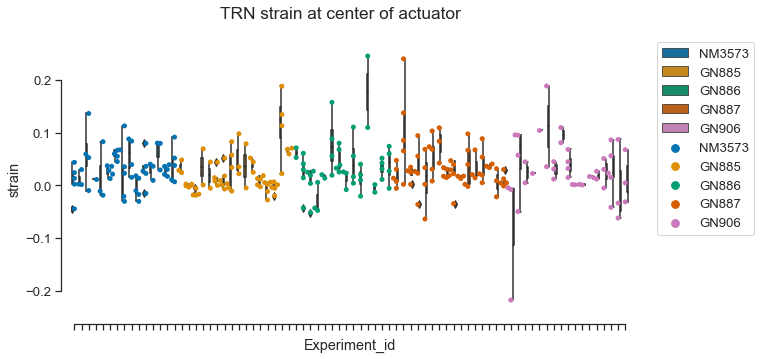

In [39]:
fig, ax = plt.subplots(figsize=(10,5))
sns.swarmplot(x='Experiment_id', y='strain', hue='worm_strain', ax=ax,
              data=central_mito_pair_df.sort_values('worm_strain'))
ax.legend(ax.artists, worm_strains)
sns.boxplot(x='Experiment_id', y='strain', hue='worm_strain', ax=ax,
            data=central_mito_pair_df.sort_values('worm_strain'))
fig.suptitle('TRN strain at center of actuator')
sns.despine(offset=10, trim=True)
ax.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90, ha='right');

### One-way ANOVA to test for statistical significance

In [40]:
center_strain_input = []
transgenic_worm_strains = [strain for strain in worm_strains if strain is not 'N2']
for this_worm_strain in transgenic_worm_strains:
    center_strain_input.append(central_mito_pair_df.loc[
        central_mito_pair_df['worm_strain'] == this_worm_strain]['strain'])
# f_stat, p_val = stats.f_oneway(*center_strain_input)
# print(f_stat, p_val)
print(stats.f_oneway(*center_strain_input))

mc = multicomp.MultiComparison(
    central_mito_pair_df['strain'], central_mito_pair_df['genotype'],
    group_order=[allele_dict[strain] for strain in worm_strains if strain is not 'N2'])
mc_results = mc.tukeyhsd()
print(mc_results)

F_onewayResult(statistic=0.6770405930222244, pvalue=0.6083879196635462)
      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
   group1       group2    meandiff p-adj   lower  upper  reject
---------------------------------------------------------------
     control him-4(e1267)  -0.0072    0.9 -0.0301 0.0156  False
     control mec-1(e1066)   0.0032    0.9 -0.0211 0.0274  False
     control mec-1(e1738)   0.0039    0.9 -0.0184 0.0261  False
     control  mec-5(u444)  -0.0053    0.9 -0.0303 0.0197  False
him-4(e1267) mec-1(e1066)   0.0104 0.7363 -0.0138 0.0346  False
him-4(e1267) mec-1(e1738)   0.0111 0.6274 -0.0111 0.0334  False
him-4(e1267)  mec-5(u444)   0.0019    0.9 -0.0231 0.0269  False
mec-1(e1066) mec-1(e1738)   0.0007    0.9 -0.0229 0.0244  False
mec-1(e1066)  mec-5(u444)  -0.0085    0.9 -0.0347 0.0177  False
mec-1(e1738)  mec-5(u444)  -0.0092 0.8181 -0.0336 0.0152  False
---------------------------------------------------------------


### Strain at center vs. time

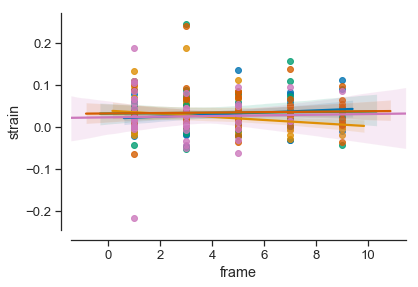

In [41]:
fig, ax = plt.subplots()
sns.despine(offset=10)
for this_strain in worm_strains:
    sns.regplot(x='frame', y='strain', ax=ax,
                data=central_mito_pair_df.loc[central_mito_pair_df['worm_strain'] == this_strain])

### Plot strain using spatial averaging

In [42]:
plot_start = time.time()

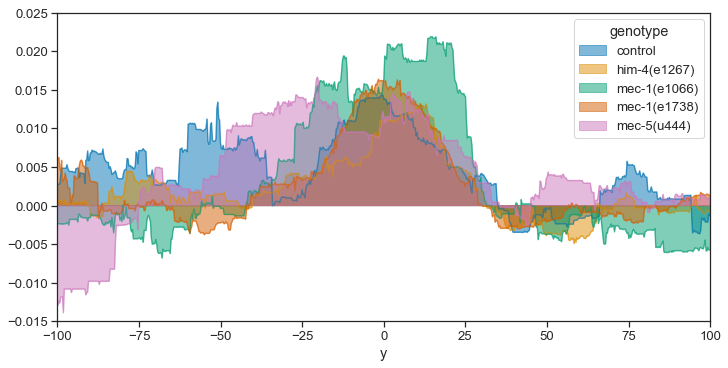

In [43]:
grouped_strain_df = spatial_strain_df.groupby(['genotype', 'y']).mean()['strain'].unstack(level=0)

fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)
grouped_strain_df.plot.area(stacked=False, ax=ax, xlim=(-100,100), ylim=(-.015, 0.025));

Plot took 2 seconds.


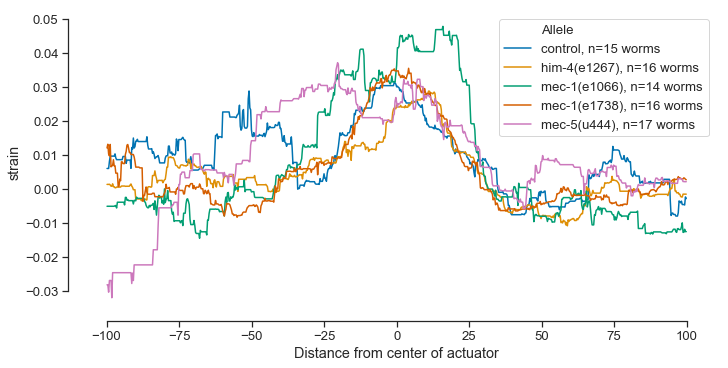

In [44]:
fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)
sns.lineplot(x='y', y='strain', ax=ax, hue='worm_strain', ci=None, # style='',
             data=spatial_strain_df.loc[(spatial_strain_df['pressure']==300) &
                                        (spatial_strain_df['y'] > -100) &
                                        (spatial_strain_df['y'] < 100)])

sns.despine(offset=10, trim=True)
h, labels = ax.get_legend_handles_labels()
labels = [(allele_dict[label] + ', n=' + str(n_trials_dict[label]) + ' worms') if label in allele_dict else 'Allele' for label in labels]
ax.legend(h, labels)
ax.set_xlabel('Distance from center of actuator')

fig.savefig(fig_save_dir + 'StrainVsPosition')
print('Plot took', str(round(time.time()-plot_start)), 'seconds.')

### Calculate FWHM of strain profiles

FWHM for control is 39.6
FWHM for him-4(e1267) is 42.075
FWHM for mec-1(e1066) is 54.45
FWHM for mec-1(e1738) is 36.85000000000001
FWHM for mec-5(u444) is 64.625


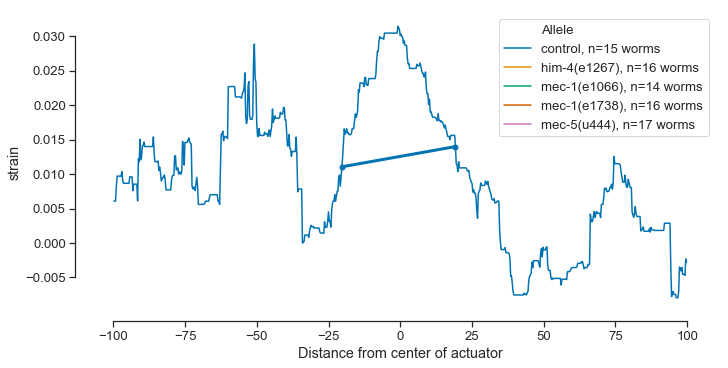

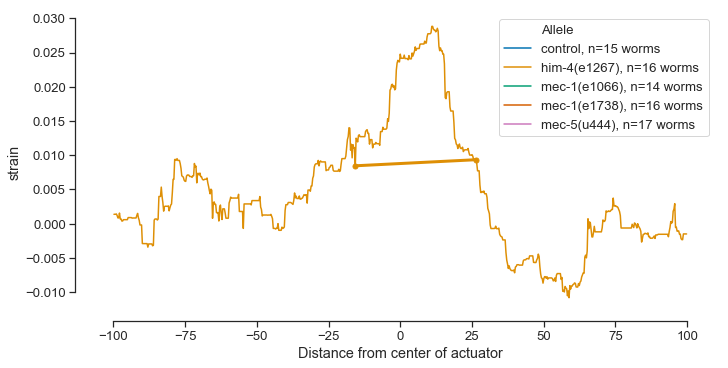

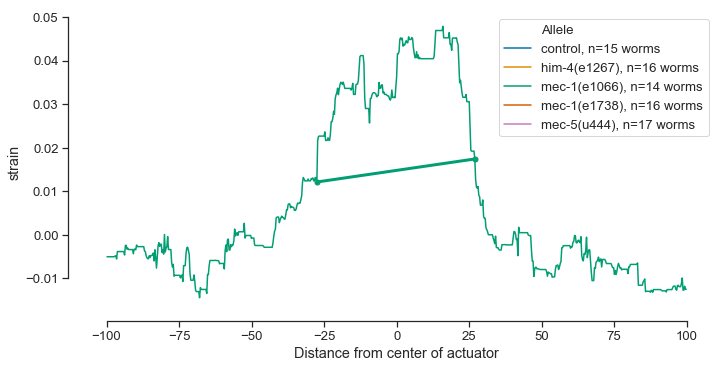

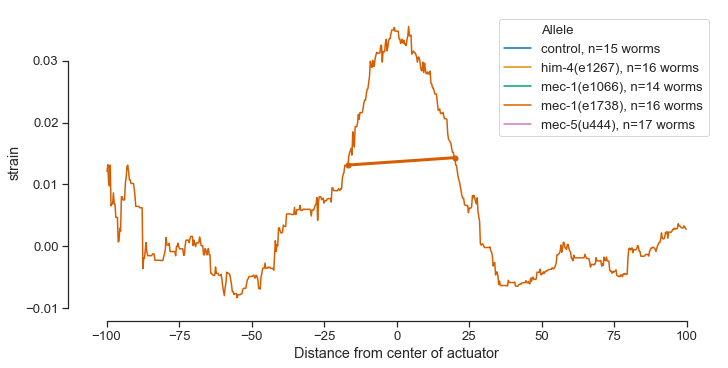

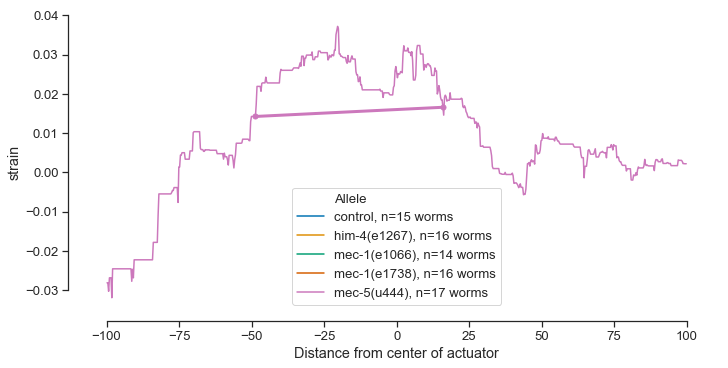

In [45]:
spatial_strain_mean_df = spatial_strain_df.loc[
    (spatial_strain_df['pressure']==300) &
    (spatial_strain_df['y']>-75) &
    (spatial_strain_df['y']<100)].groupby(['genotype', 'y'], as_index=False).mean()
for genotype in spatial_strain_df['genotype'].unique():
    max_index = spatial_strain_mean_df.loc[(spatial_strain_mean_df['genotype']==genotype)]['strain'].idxmax()
    max_strain = spatial_strain_mean_df.loc[max_index]['strain']
    min_index = spatial_strain_mean_df.loc[(spatial_strain_mean_df['genotype']==genotype)]['strain'].idxmin()
    min_strain = spatial_strain_mean_df.loc[min_index]['strain']
    
    half_max_strain = (max_strain - min_strain) / 2 + min_strain
    
    spatial_strain_mean_df['next_strain'] = spatial_strain_mean_df['strain'].shift(-1)
    half_max_y_min = spatial_strain_mean_df.loc[(spatial_strain_mean_df['strain']-half_max_strain<=0) &
                                                (spatial_strain_mean_df['next_strain']-half_max_strain>0) &
                                                (spatial_strain_mean_df['y'] < 0) &
                                                (spatial_strain_mean_df['genotype']==genotype)]['y'].idxmax()

    half_max_y_min = spatial_strain_mean_df.iloc[half_max_y_min]
    half_max_y_max = spatial_strain_mean_df.loc[(spatial_strain_mean_df['strain']-half_max_strain>=0) &
                                                (spatial_strain_mean_df['next_strain']-half_max_strain<0) &
                                                (spatial_strain_mean_df['y'] > 0) &
                                                (spatial_strain_mean_df['genotype']==genotype)]['y'].idxmin()
    half_max_y_max= spatial_strain_mean_df.iloc[half_max_y_max]
    
    
    fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)
    sns.lineplot(x='y', y='strain', ax=ax, hue='worm_strain', ci=None, # style='',
                 data=spatial_strain_df.loc[(spatial_strain_df['pressure']==300) &
                                            (spatial_strain_df['y'] > -100) &
                                            (spatial_strain_df['y'] < 100) &
                                            (spatial_strain_df['genotype']==genotype)])

    sns.despine(offset=10, trim=True)
    h, labels = ax.get_legend_handles_labels()
    labels = [(allele_dict[label] + ', n=' + str(n_trials_dict[label]) + ' worms')
              if label in allele_dict else 'Allele' for label in labels]
    ax.legend(h, labels)
    ax.set_xlabel('Distance from center of actuator')
    color = sns.color_palette()[spatial_strain_df['genotype'].unique().tolist().index(genotype)]
    ax.plot([half_max_y_min['y'], half_max_y_max['y']],
            [half_max_y_min['strain'], half_max_y_max['strain']],
            color=color, marker='o',  markersize=5, linestyle='-', linewidth=3)

    print('FWHM for', genotype, 'is', str(half_max_y_max['y']-half_max_y_min['y']))

### Plot stretch using spatial averaging

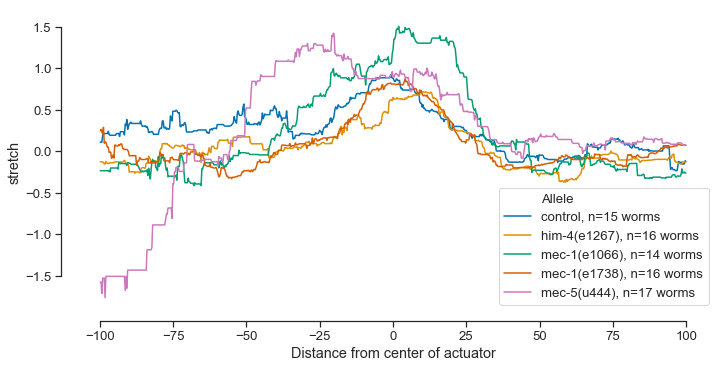

In [46]:
fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)
sns.lineplot(x='y', y='stretch', ax=ax, hue='worm_strain', ci=None, # style='',
             data=spatial_strain_df.loc[(spatial_strain_df['pressure']==300) &
                                        (spatial_strain_df['y'] > -100) &
                                        (spatial_strain_df['y'] < 100)])

sns.despine(offset=10, trim=True)
h, labels = ax.get_legend_handles_labels()
labels = [(allele_dict[label] + ', n=' + str(n_trials_dict[label]) + ' worms') if label in allele_dict else 'Allele' for label in labels]
ax.legend(h, labels)
ax.set_xlabel('Distance from center of actuator');

### Spatial distribution of strain from a single genotype

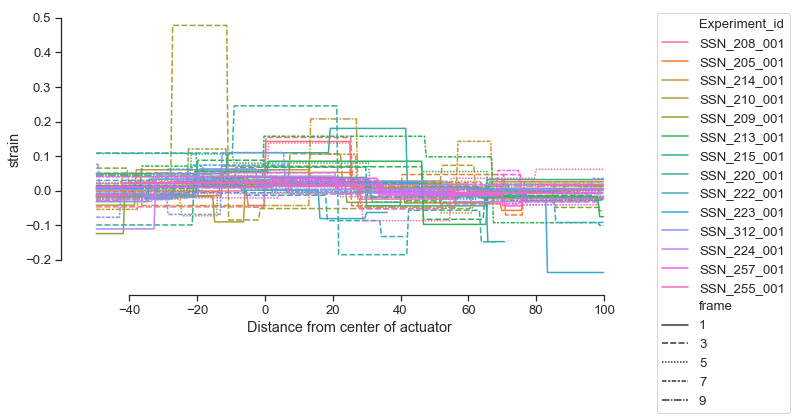

In [47]:
fig, ax = plt.subplots(figsize=(10,5))
sns.lineplot(x='y', y='strain', ax=ax, hue='Experiment_id', style='frame', # ci=None, # style='',
             data=spatial_strain_df.loc[(spatial_strain_df['pressure'] == 300) &
                                        (spatial_strain_df['worm_strain'] == 'GN886') &
                                        (spatial_strain_df['y'] > -50) &
                                        (spatial_strain_df['y'] < 100)])

sns.despine(offset=10, trim=True)
ax.legend()
plt.legend(bbox_to_anchor=(1.05, 1), borderaxespad=0.)
ax.set_xlabel('Distance from center of actuator');

Need to check SSN_255_001, SSN_220_001, and SSN_210_001 for outlier problems

### Max displacement vs. max strain

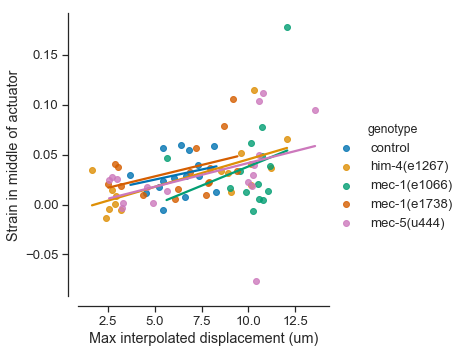

In [48]:
def get_strain_at_actuator(row):
    strain_val = spatial_strain_df.loc[
        (spatial_strain_df['Experiment_id'] == row['Experiment_id']) &
        (spatial_strain_df['pressure'] != 0) &
        (spatial_strain_df['y_coord'] == 0)]['strain'].mean()
    return strain_val    

fit_param_df['strain_at_actuator'] = fit_param_df.apply(get_strain_at_actuator, axis=1)

def get_max_dist_to_central_pair_df(row):
    max_dist = fit_param_df.loc[
        (fit_param_df['Experiment_id'] == row['Experiment_id'])]['max_dist'].values[0]
    
    return max_dist

central_mito_pair_df['max_dist'] = central_mito_pair_df.apply(get_max_dist_to_central_pair_df, axis=1)

# fig, ax = plt.subplots(constrained_layout=True)
# for this_strain in worm_strains:
#     sns.regplot(x='max_dist', y='strain_at_actuator', x_ci=None, ci=None, # hue='genotype',
#                 data=fit_param_df.loc[fit_param_df['worm_strain'] == this_strain])
fig = sns.lmplot(x='max_dist', y='strain_at_actuator', hue='genotype', ci=None,
               truncate=True, data=fit_param_df)
sns.despine(offset=10)
fig.set_axis_labels('Max interpolated displacement (um)', 'Strain in middle of actuator')
# ax.set_title('Strain vs. max displacement')
# ax.set_xlabel('Max interpolated displacement (um)')
# ax.set_ylabel('Strain in middle of actuator')
# ax.legend(['wild-type', 'him-4(e1267)', 'mec-1(e1066)', 'mec-1(e1738)'])

fig.savefig(fig_save_dir + 'strain_vs_max_displacement')



### Strain in frames with no actuation
Useful for estimating uncertainty of touch-induced mechanical strain measurement

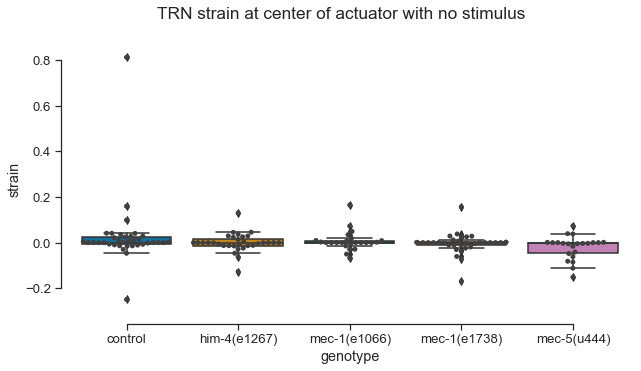

In [49]:
central_mito_pair_pressure_off = mito_pairs_pressure_off.loc[
    ((mito_pair_df['particle_1_yval'] < 0) != 
     (mito_pair_df['particle_2_yval'] < 0)) &
     (mito_pair_df['pressure'] != 0)].copy()
central_mito_pair_pressure_off['worm_strain'] = central_mito_pair_pressure_off[
    'worm_strain'].astype(worm_strain_categories)
central_mito_pair_pressure_off.sort_values('worm_strain', inplace=True)

fig, ax = plt.subplots(figsize=(10,5))
sns.boxplot(x='genotype', y='strain', data=central_mito_pair_pressure_off, ax=ax)
sns.swarmplot(x='genotype', y='strain', color=".25", data=central_mito_pair_pressure_off, ax=ax)
# ax.legend(ax.artists, worm_strains, bbox_to_anchor=(1.05, 1), borderaxespad=0.)
fig.suptitle('TRN strain at center of actuator with no stimulus')
sns.despine(offset=10, trim=True)


In [50]:
spatial_strain_avg_no_pressure_list = []
for index, row in mito_pairs_pressure_off.iterrows():
    y1_pixel = math.ceil(row['particle_1_yval'] / pixel_to_micron)
    y2_pixel = math.floor(row['particle_2_yval'] / pixel_to_micron)
    for y_coord in range(y1_pixel, y2_pixel):
        new_row_dict = {
            'Experiment_id': row['Experiment_id'],
            'frame': row['frame'],
            'pair_id': row['pair_id'],
            'pressure': row['pressure'],
            'max_actuation': row['max_actuation'],
            'worm_strain': row['worm_strain'],
            'genotype': row['genotype'],
            'stretch': row['stretch'],
            'strain': row['strain'],
            'y_coord': y_coord,
            'y': y_coord * pixel_to_micron}
        spatial_strain_avg_no_pressure_list.append(new_row_dict)
            
no_pressure_spatial_strain_df = pd.DataFrame(spatial_strain_avg_no_pressure_list)
no_pressure_spatial_strain_df['worm_strain'] = no_pressure_spatial_strain_df[
    'worm_strain'].astype(worm_strain_categories)
no_pressure_spatial_strain_df.sort_values('worm_strain', inplace=True)

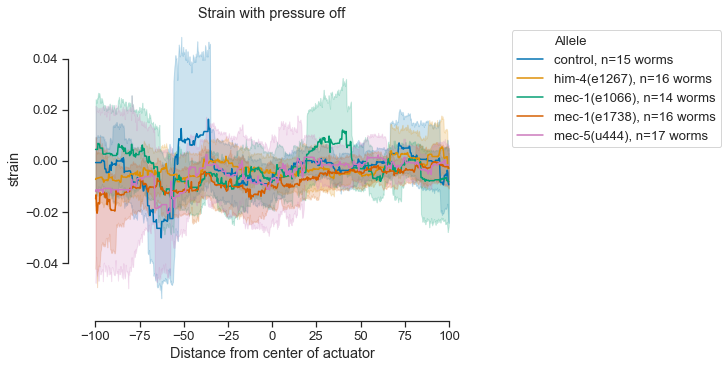

In [51]:
fig, ax = plt.subplots(figsize=(10,5), constrained_layout=True)
sns.lineplot(x='y', y='strain', ax=ax, hue='worm_strain', #ci=None, # style='',
             data=no_pressure_spatial_strain_df.loc[(no_pressure_spatial_strain_df['y'] > -100) &
                                                    (no_pressure_spatial_strain_df['y'] < 100)])

sns.despine(offset=10, trim=True)
h, labels = ax.get_legend_handles_labels()
labels = [(allele_dict[label] + ', n=' + str(n_trials_dict[label]) + ' worms') if label in allele_dict else 'Allele' for label in labels]
ax.legend(h, labels, bbox_to_anchor=(1.1, 1.))
ax.set_xlabel('Distance from center of actuator')
ax.set_title('Strain with pressure off')

fig.savefig(fig_save_dir + 'strain_no_actuation.eps')

## Exploratory data analysis

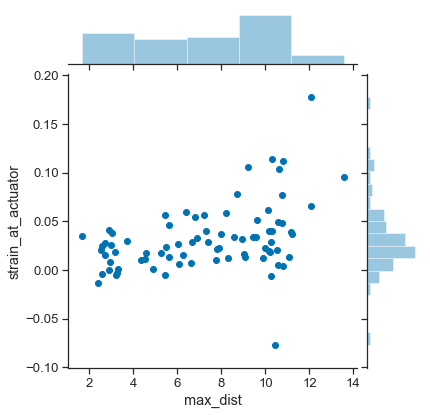

In [52]:
sns.jointplot(x='max_dist', y='strain_at_actuator', data=fit_param_df);

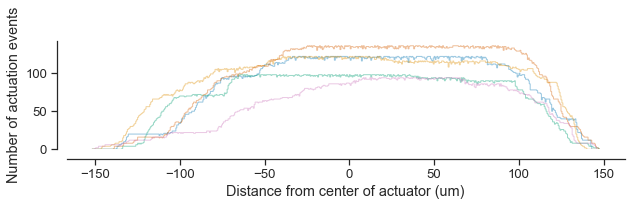

In [53]:
fig, ax = plt.subplots(figsize=(10,2))
for strain in worm_strains:
    sns.distplot(a=spatial_strain_df.loc[
        (spatial_strain_df['worm_strain'] == strain) &
        (spatial_strain_df['pressure'] != 0)]['y'], kde=False,
                 hist_kws={'histtype': 'step'}, ax=ax,
                 bins=np.arange(spatial_strain_df['y'].min(),
                                spatial_strain_df['y'].max(), pixel_to_micron*2))

ax.set_xlabel('Distance from center of actuator (um)')
ax.set_ylabel('Number of actuation events')
sns.despine(offset=10)

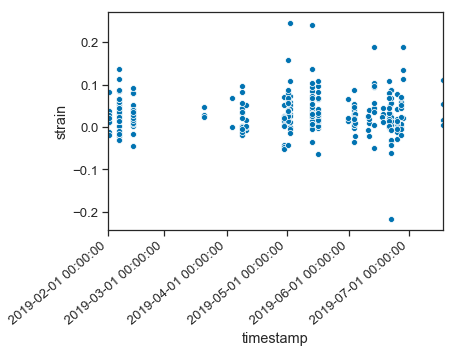

In [54]:
ax = sns.scatterplot(x='timestamp', y='strain', data=central_mito_pair_df)
ax.set_xlim((central_mito_pair_df['timestamp'].min(), central_mito_pair_df['timestamp'].max()))
first_timestamp = central_mito_pair_df['timestamp'].min()
last_timestamp = central_mito_pair_df['timestamp'].max()
labels = [time for time in pd.date_range(start=first_timestamp, end=last_timestamp, freq='MS', normalize=True)]
ax.set_xticks(labels)
ax.set_xticklabels(labels, rotation=40, ha='right');

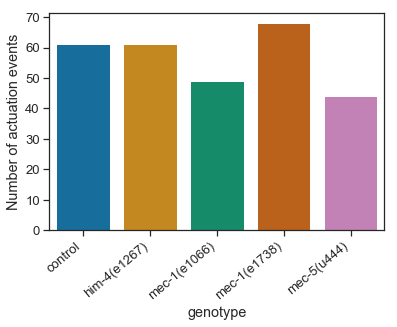

In [55]:
# linked_mitos_df.groupby(['genotype']).count()
ax = sns.countplot(x='genotype', data=central_mito_pair_df)
ax.set_xticklabels(labels=ax.get_xticklabels(), rotation=40, ha='right')
ax.set_ylabel('Number of actuation events');

## Plots for figure 1 of paper
This figure is intended to show how the method for measuring strain works. I've chosen a trial with the maximum number of actuation events so it can be averaged.

- A) Max projection of mitochondria in the TRN of a worm. 
- B) Motion of mitochondria induced by mechanical stimulus. 
- C) Mechanical strain in the TRN at the location of maximum actuation. 
- D) Distribution of touch-induced strain in the TRN

In [56]:
example_trial = 'SSN_161_001'
timestamp = metadata_df.loc[metadata_df['Experiment_id'] == example_trial]['timestamp'].values[0]
exp_dir = ''.join(str(timestamp)[:10].split('-'))
filename = pathlib.Path(raw_data_dir, exp_dir, example_trial + '.nd2')
bf_filename = filename.parent.joinpath(filename.stem + '_bf.nd2')
warnings.filterwarnings("ignore", message="Reported average frame interval")

In [57]:
bf_image = pims.open(str(bf_filename))
bf_array = np.asarray(bf_image)
bf_array = bf_array.squeeze()
bf_array = np.rot90(bf_array,1,(0,1))

images = pims.open(str(filename))
images.bundle_axes = ['z', 'y', 'x']

imageArray = np.asarray(images)
imageArray = imageArray.squeeze()

maxProjection = np.amax(imageArray[0:2] ,1) # collapse z axis
maxProjection = maxProjection.squeeze()
maxProjection = np.asarray(maxProjection)
maxProjection = np.rot90(maxProjection,1,(1,2))

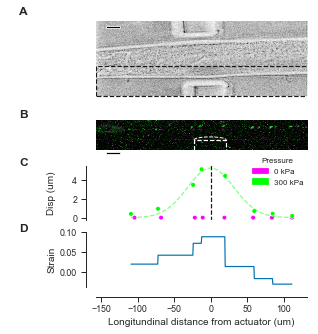

In [96]:
sns.set(font_scale=1, font='Arial')
sns.set_style(style='ticks')
sns.set_palette('colorblind')
sns.set_context('paper', rc={"font.size":12,
                             'pdf.fonttype': 42,
                             'ps.fonttype': 42,
                             "axes.titlesize":10,
                             "axes.labelsize":10,
                             'legend.fontsize': 8,
                             'legend.title_fontsize': 8})
# matplotlib.rcParams['pdf.fonttype'] = 42
# matplotlib.rcParams['ps.fonttype'] = 42

# Corrections for coordinates of image and data
middle_actuator_estimate = trials_for_analysis.loc[
    trials_for_analysis['Experiment_id'] == example_trial]['actuator_center'].values[0][1] * pixel_to_micron
disp_fit_correction = fit_param_df.loc[
        fit_param_df['Experiment_id'] == row['Experiment_id']][
        'max_dist_location'].values[0]
left_side_of_image = 0 - (middle_actuator_estimate + disp_fit_correction)
right_side_of_image = maxProjection.shape[2] * pixel_to_micron + left_side_of_image
top_of_image = 300
bottom_of_image = 450
actuator_left = 490
actuator_width = 160
actuator_right = actuator_left + actuator_width
actuator_top = 100
bf_image_top = 75
bf_image_bottom = -150
scale_bar_length_microns = 20

# Colors and display settings
vmax = 150
vmin = maxProjection.min()
n_colors = int(vmax - vmin + 1)
background_color = 'black'
background_val = mpl.colors.to_rgba(background_color)
before_act_color = 'magenta'
before_color_val = mpl.colors.to_rgba(before_act_color)
after_act_color = 'lime'
after_color_val = mpl.colors.to_rgba(after_act_color)
actuator_outline_color = 'white'

cmap_floor = 0.2
cmap_ceil = 0.9

magenta_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'my_magenta', [background_color, before_act_color], N=n_colors)
magenta_cmap = mpl.colors.ListedColormap(
    np.vstack((np.tile(background_val, (int(n_colors*cmap_floor), 1)),
               magenta_cmap(np.linspace(0, 1, int(n_colors*(cmap_ceil-cmap_floor)))),
               np.tile(before_color_val, (int(n_colors*cmap_ceil), 1)))))
magenta_patch = mpl.patches.Patch(color=before_act_color, label='0 kPa')

green_cmap = mpl.colors.LinearSegmentedColormap.from_list(
    'my_green', [background_color, after_act_color], N=n_colors)
green_cmap = mpl.colors.ListedColormap(
    np.vstack((np.tile(background_val, (int(n_colors*cmap_floor), 1)),
               green_cmap(np.linspace(0, 1, int(n_colors*(cmap_ceil-cmap_floor)))),
               np.tile(after_color_val, (int(n_colors*cmap_ceil), 1)))))
green_patch = mpl.patches.Patch(color=after_act_color, label='300 kPa')
spectrum_for_actuation = mpl.colors.LinearSegmentedColormap.from_list('my_spec', ['#FF00FF', '#00FF00'], N=256)

# Create Figure
fig, axes = plt.subplots(4, 2, figsize=(5, 5), constrained_layout=False,
                         gridspec_kw={'height_ratios':[2.5, 1, 1.5, 1.5], 'width_ratios':[1,5],
                                      'hspace':0.2})

# Panel Labels
for letter, ax in zip(['A', 'B', 'C', 'D'], range(0,4)):
    axes[ax, 0].text(-0.2, 1, letter, weight='bold')
    axes[ax, 0].axis('off')

# Brightfield image of worm in device
axes[0, 1].imshow(np.fliplr(bf_array[bf_image_top:bf_image_bottom]), cmap='gray_r') # try top_of_image:bottom_of_image to see how that looks
# dotted line to show subset of image used for next panel
axes[0, 1].plot([1, 1, bf_array.shape[1]-1, bf_array.shape[1]-1, 1],
             [bottom_of_image-bf_image_top, top_of_image-bf_image_top,
              top_of_image-bf_image_top, bottom_of_image-bf_image_top, bottom_of_image-bf_image_top], '--k')
scale_bar = mpl.patches.Rectangle((50, 25), height=10,
                                  width=scale_bar_length_microns/pixel_to_micron, facecolor='black')
axes[0, 1].add_patch(scale_bar)
axes[0, 1].axis('off')


# Overlay of fluorescence image of mitos before and after actuation
axes[1, 1].imshow(np.fliplr(maxProjection[0, top_of_image:bottom_of_image,]),
               cmap=magenta_cmap, alpha=1, vmax=vmax, vmin=vmin) # before actuation
axes[1, 1].imshow(np.fliplr(maxProjection[1, top_of_image:bottom_of_image,]),
               cmap=green_cmap, alpha=0.7, vmax=vmax, vmin=vmin) # after actuation
axes[1, 1].plot([actuator_left, actuator_left, actuator_right, actuator_right],
                [bottom_of_image-top_of_image, actuator_top, actuator_top, bottom_of_image-top_of_image],
                color=actuator_outline_color, linestyle='--')
arc = mpl.patches.Arc(((actuator_left+actuator_right)/2, actuator_top),
                      actuator_right-actuator_left, 30, 0, 180,
                      linewidth=1, color=actuator_outline_color, linestyle='--') # diagram of actuator location
axes[1, 1].add_patch(arc)
scale_bar = mpl.patches.Rectangle((50, 160), height=10, clip_on=False,
                                  width=scale_bar_length_microns/pixel_to_micron, facecolor='black')
axes[1, 1].add_patch(scale_bar)
axes[1, 1].axis('off')


# get data to plot fit
min_y = linked_mitos_df.loc[(linked_mitos_df['Experiment_id']==example_trial)]['y'].min()
max_y = linked_mitos_df.loc[(linked_mitos_df['Experiment_id']==example_trial)]['y'].max()
y_coords = list(range(int(min_y), int(max_y)))
example_fit_df = pd.DataFrame({'y': y_coords})
example_fit_params = individual_fit_param_df.loc[(individual_fit_param_df['Experiment_id'] == example_trial) &
                            (individual_fit_param_df['frame'] == 1)]
example_fit_df['indent_fit'] = example_fit_df.apply(
    lambda row: transformed_normal(row['y'],
                                   0,
                                   example_fit_params['normal_scale_param'],
                                   example_fit_params['normal_magnitude_param']), axis=1)

sns.scatterplot(x='y', y='x_dist', hue='pressure', ax=axes[2, 1], palette=spectrum_for_actuation, legend=None,
                data=linked_mitos_df.loc[(linked_mitos_df['Experiment_id']==example_trial) & 
                                         (linked_mitos_df['frame'] <= 1)])
sns.lineplot(x='y', y='indent_fit', data=example_fit_df, ax=axes[2, 1], ci=None,
             color=spectrum_for_actuation(256)[0:3], marker=None, alpha=0.5)
axes[2, 1].lines[0].set_linestyle("--")
axes[2, 1].set_xlim([left_side_of_image, right_side_of_image])
axes[2, 1].set_ylabel('Disp (um)')
leg = axes[2, 1].legend([magenta_patch, green_patch], ['0 kPa', '300 kPa'],
                        title='Pressure', frameon=False, loc='upper right', fontsize=8,
                        bbox_to_anchor=(1., 1.2), borderaxespad=0.)
leg.get_title().set_fontsize(8)
ylim = axes[2, 1].get_ylim()
axes[2, 1].plot([0, 0],[-1, 10], '--k')
axes[2, 1].set_ylim(ylim)
axes[2, 1].get_xaxis().set_visible(False)
sns.despine(ax=axes[2, 1], offset=10, trim=False, bottom=True)


sns.lineplot(x='y', y='strain', hue='genotype', style='pressure', ax=axes[3, 1], ci=None, palette=None,
                data=spatial_strain_df.loc[(spatial_strain_df['pressure'] == 300) &
                                           (spatial_strain_df['Experiment_id'] == example_trial) &
                                           (spatial_strain_df['frame'] == 1)])
# sns.lineplot(x='y', y='strain', hue='genotype', style='frame', dashes=[(3,3),(3,3),(3,3),(3,3),],
#              ax=axes[3, 1], ci=None, palette=None, alpha=0.5,
#              data=spatial_strain_df.loc[(spatial_strain_df['pressure'] == 300) &
#                                            (spatial_strain_df['Experiment_id'] == example_trial)])
axes[3, 1].set_xlim([left_side_of_image, right_side_of_image])
axes[3, 1].set_xlabel('Longitundinal distance from actuator (um)')
ylim = axes[3, 1].get_ylim()
axes[3, 1].set_ylim([ylim[0], 0.1])
axes[3, 1].set_ylabel('Strain')
axes[3, 1].legend().set_visible(False)
sns.despine(ax=axes[3, 1], offset=10, trim=False)


# Save fig
fig.align_labels()
fig.savefig(fig_save_dir + 'DispOverlay.pdf')

## Plots for figure 2 of paper
This figure shows what the strain profile of wild-type worms.

- A) Spatially averaged strain profile
- B) Plot of strain vs displacement at actuator

In [59]:
ctrl_filenames = ['ATT_002_001.xlsx',
                  'ATT_002_002.xlsx',
                  'ATT_002_003.xlsx']

base_folder = pathlib.Path('/Users/adam/Documents/SenseOfTouchResearch/TouchTests')

def get_touch_test_df(base_folder, filenames):
    list_of_df_from_sheets = []
    for data_file in filenames:
        data_file_path = base_folder.joinpath(data_file)
        all_sheets = pd.read_excel(data_file_path, sheet_name=None, header=0)
        for sheet in all_sheets.keys():
            current_metadata = all_sheets[sheet].iloc[27:29, 0:5]
            current_metadata.columns = current_metadata.iloc[0]
            current_metadata = current_metadata[1:]

            if not current_metadata.empty:  # filter out empty sheets
                this_sheet_df = all_sheets[sheet].iloc[0:25].melt(
                    id_vars='Trials', value_vars=['Touch'+str(touch_num) for touch_num in range(1,11)])
                this_sheet_df['date'] = current_metadata['Date'].values[0]
                this_sheet_df['temperature'] = current_metadata['Temperat.'].values[0]
                this_sheet_df['humidity'] = current_metadata['Humidity'].values[0]
                this_sheet_df['strain_code'] = current_metadata['StrainCod'].values[0]
                this_sheet_df['strain_name'] = current_metadata['StrainDecod'].values[0]
                this_sheet_df['genotype'] = this_sheet_df['strain_name'].replace(allele_dict)
                this_sheet_df['variable'] = this_sheet_df['variable'].str.slice(start=5).astype('int')
                this_sheet_df.rename(columns={'Trials': 'worm_num',
                                              'variable': 'touch_num',
                                              'value': 'touch_outcome'}, inplace=True)
                list_of_df_from_sheets.append(this_sheet_df)

    each_touch_result_df = pd.concat(list_of_df_from_sheets)
    each_touch_result_df.fillna(0, downcast='infer', inplace=True)
    each_touch_result_df['touch_outcome'] = each_touch_result_df['touch_outcome'].astype('int')

#     print(each_touch_result_df['genotype'].unique())
    result_by_worm = each_touch_result_df.groupby(
        ['strain_name', 'genotype', 'strain_code', 'date', 'worm_num']).mean().reset_index().drop(
        axis='columns', labels='touch_num')
    if 'N2' not in worm_strains:
        worm_strains.append('N2')
    
    touch_test_strains_categories = pd.api.types.CategoricalDtype(
        categories=worm_strains, ordered=True)
    if 'N2' in result_by_worm['strain_name'].unique():
        each_touch_result_df['strain_name'] = each_touch_result_df['strain_name'].astype(
            touch_test_strains_categories)
        result_by_worm['strain_name'] = result_by_worm['strain_name'].astype(touch_test_strains_categories)
    else:
        each_touch_result_df['strain_name'] = each_touch_result_df['strain_name'].astype(
            worm_strain_categories)
        result_by_worm['strain_name'] = result_by_worm['strain_name'].astype(worm_strain_categories)
    
    
    return result_by_worm

# transgenic_results = get_touch_test_df(base_folder, ctrl_filenames)
# dabest.TwoGroupsEffectSize(
#     control=transgenic_results.loc[transgenic_results['genotype']=='wild-type']['touch_outcome'].values,
#     test=transgenic_results.loc[transgenic_results['genotype']=='control']['touch_outcome'].values,
#     effect_size='mean_diff')

# trangenic_est_plot_data = dabest.load(transgenic_results, x='genotype', y='touch_outcome',
#                                       idx=('wild-type', 'control'))
# est_fig = trangenic_est_plot_data.mean_diff.plot(
#     raw_marker_size=4, 
#     group_summaries='median_quartiles',
#     fig_size=(2.5, 2),
#     custom_palette=[sns.color_palette()[5], # dabest palette order is weird, so rearrange it
#                     sns.color_palette()[0]]) # 3.2 x 2

The unpaired mean difference is 0.00667 [95%CI -0.0347, 0.048].
The two-sided p-value of the Mann-Whitney test is 0.983.

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.

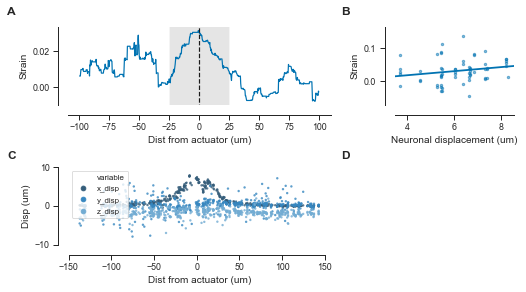

In [143]:
# Create Figure
fig = plt.figure(constrained_layout=False, figsize=(8, 4))
gs = fig.add_gridspec(2, 3, wspace=0.6, hspace=0.8,
                      width_ratios=[20, 5, 15])
panel_A_ax = fig.add_subplot(gs[0, 0:2])
panel_B_ax = fig.add_subplot(gs[0, 2])
disp_ax = fig.add_subplot(gs[1, 0:2])
diagram_ax = fig.add_subplot(gs[1, 2])    
    
# Make plots
# Panel A
sns.lineplot(x='y', y='strain', hue='genotype', palette=None,
             legend=None, ax=panel_A_ax, ci=None,
             data=spatial_strain_df.loc[(spatial_strain_df['pressure'] == 300) &
                                        (spatial_strain_df['worm_strain'] == 'NM3573')&
                                        (spatial_strain_df['y'] > -100) &
                                        (spatial_strain_df['y'] < 100)])
panel_A_ax.set_xlabel('Dist from actuator (um)')
panel_A_ax.set_ylabel('Strain')
# Create a rectangle to show where actuator is
rect = mpl.patches.Rectangle((-25,-1), width=50, height=2, facecolor='gray', alpha=0.2)
panel_A_ax.add_patch(rect)
ylim = panel_A_ax.get_ylim()
panel_A_ax.plot([0, 0],[-1, 1], '--k')
panel_A_ax.set_ylim(ylim)
sns.despine(ax=panel_A_ax, offset=10)

# Panel B
sns.regplot(x='max_dist', y='strain', ax=panel_B_ax, scatter_kws={'alpha':0.5}, marker='.', ci=None, 
            data=central_mito_pair_df.loc[central_mito_pair_df['worm_strain'] == 'NM3573'])
panel_B_ax.set_xlabel('Neuronal displacement (um)')
panel_B_ax.set_ylabel('Strain')
sns.despine(ax=panel_B_ax, offset=10)

# Panel C
# transgenic_results = get_touch_test_df(base_folder, ctrl_filenames);
# trangenic_est_plot_data = dabest.load(transgenic_results, x='genotype', y='touch_outcome',
#                                       idx=('wild-type', 'control'))
# trangenic_est_plot_data.mean_diff.plot(
#     raw_marker_size=3, 
#     es_marker_size=4.5,
#     group_summaries='median_quartiles',
#     custom_palette=[sns.color_palette()[5], # dabest palette order is weird, so rearrange it
#                     sns.color_palette()[0]],
#     ax=est_plot_ax)
# est_plot_ax.set_ylabel('Response probability')
# pos = est_plot_ax.get_position()
# left_shift = 0.018
# pos.x0 -= left_shift
# pos.x1 -= left_shift
# est_plot_ax.set_position(pos)

# Revision panel C
disp_data_to_plot = linked_mitos_df.loc[(linked_mitos_df['genotype']=='control') & 
                                        (linked_mitos_df['pressure']!=0)].copy()

def fix_x_disp_sign(row):
    """Fixes sign change due to using actuator on left side of FOV.
    
    Uses information in the metadata to make sure the displacement in x-dir has the right sign. 
    Note that this is not necessary in the other directions due to symmetry"""
    current_metadata = trials_for_analysis.loc[trials_for_analysis['Experiment_id'] == row['Experiment_id']]
    
    if current_metadata['vulva_orientation'].str.contains('West').all():
        disp_sign = -1
    elif current_metadata['vulva_orientation'].str.contains('East').all():
        disp_sign = 1
    else:
        raise ValueError
    return disp_sign * row['x_disp']

disp_data_to_plot['x_disp'] = disp_data_to_plot.apply(fix_x_disp_sign, axis=1)
disp_data_to_plot = disp_data_to_plot.melt(
    id_vars=['Experiment_id','frame','particle', 'y'],
    value_vars=['x_disp', 'y_disp', 'z_disp'],
    value_name='disp')
sns.scatterplot(x='y', y='disp', hue='variable', ax=disp_ax, data=disp_data_to_plot, #legend=False, 
                palette="Blues_d", alpha=0.8, marker='.', edgecolor='')
disp_ax.set_xlabel('Dist from actuator (um)')
disp_ax.set_ylabel('Disp (um)')
disp_ax.set_yticks([-10, 0, 10])
sns.despine(ax=disp_ax, offset=10, trim=True)



diagram_ax.axis('off')

# Panel labels
fig.text(x=0.02, y=0.95, s='A', weight='bold', va='top')
fig.text(x=0.6, y=0.95, s='B', weight='bold', va='top')
fig.text(x=0.02, y=0.45, s='C', weight='bold', va='top')
fig.text(x=0.6, y=0.45, s='D', weight='bold', va='top')

fig.savefig(fig_save_dir + 'WildTypeStrain.pdf')

dabest.TwoGroupsEffectSize(
    control=transgenic_results.loc[transgenic_results['genotype']=='wild-type']['touch_outcome'].values,
    test=transgenic_results.loc[transgenic_results['genotype']=='control']['touch_outcome'].values,
    effect_size='mean_diff')

In [125]:
linked_mitos_df#.loc[
#     (linked_mitos_df['genotype']=='control') & (linked_mitos_df['pressure']!=0)].melt(id_vars=['Experiment_id','frame','particle', 'y'], value_vars=['x_disp', 'y_disp', 'z_disp'], value_name='disp')

,frame,particle,pressure,x,y,z,Experiment_id,worm_strain,genotype,x_rest,y_rest,z_rest,x_dist,y_dist,z_dist,xz_dist,xyz_dist,x_disp,y_disp,z_disp
4,0,11,0,65.943395,-84.191086,10.735983,SSN_148_001,NM3573,control,65.943395,-84.191086,10.735983,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
5,0,13,0,65.537994,-41.036577,10.476185,SSN_148_001,NM3573,control,65.537994,-41.036577,10.476185,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0,10,0,63.884035,-15.420145,10.655395,SSN_148_001,NM3573,control,63.884035,-15.420145,10.655395,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0,7,0,62.694646,6.035289,10.981187,SSN_148_001,NM3573,control,62.694646,6.035289,10.981187,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0,9,0,63.494016,30.498971,11.479193,SSN_148_001,NM3573,control,63.494016,30.498971,11.479193,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
0,0,2,0,63.747489,94.087372,15.110846,SSN_148_001,NM3573,control,63.747489,94.087372,15.110846,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
11,1,11,300,65.392838,-78.360026,6.049980,SSN_148_001,NM3573,control,65.943395,-84.191086,10.735983,0.550557,5.831059,4.686003,4.718235,7.500866,-0.550557,5.831059,-4.686003
8,1,13,300,65.691461,-38.533320,6.876317,SSN_148_001,NM3573,control,65.537994,-41.036577,10.476185,0.153468,2.503257,3.599868,3.603138,4.387357,0.153468,2.503257,-3.599868
6,1,10,300,67.821537,-15.436454,6.673556,SSN_148_001,NM3573,control,63.884035,-15.420145,10.655395,3.937502,0.016310,3.981839,5.599907,5.599931,3.937502,-0.016310,-3.981839
7,1,7,300,67.928567,5.815636,6.551711,SSN_148_001,NM3573,control,62.694646,6.035289,10.981187,5.233921,0.219653,4.429476,6.856689,6.860207,5.233921,-0.219653,-4.429476


In [61]:
stats.linregress(x=central_mito_pair_df.loc[central_mito_pair_df['worm_strain']=='NM3573']['max_dist'],
                 y=central_mito_pair_df.loc[central_mito_pair_df['worm_strain']=='NM3573']['strain'])

LinregressResult(slope=0.0061228923787366215, intercept=-0.006746008991842595, rvalue=0.20557297816531206, pvalue=0.11197291257011285, stderr=0.0037947952565624624)

## Plots for figure 3
Add information about mutants

done plotting control
done plotting him-4(e1267)
done plotting mec-1(e1066)
done plotting mec-1(e1738)
done plotting mec-5(u444)


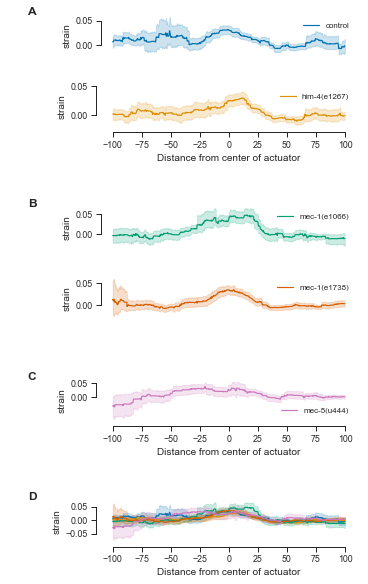

In [62]:
fig, axes = plt.subplots(nrows=9, ncols=2, figsize=(5,8), constrained_layout=True,
                        gridspec_kw={'width_ratios': [1, 20],
                                     'height_ratios': [1, 1, 0.01, 1, 1, 0.01, 1, 0.01, 1],
                                     'hspace': 0})

# Panel Labels
axes[0, 0].text(0, 1, 'A', weight='bold')
axes[3, 0].text(0, 1, 'B', weight='bold')
axes[6, 0].text(0, 1, 'C', weight='bold')
axes[8, 0].text(0, 1, 'D', weight='bold')

# Turn off unused axes
for ax in axes[:, 0]:
    ax.axis('off')
for ax_num in [2, 5, 7]:
    axes[ax_num, 1].tick_params(axis='both', which='major', labelsize=2)
    axes[ax_num, 1].axis('off')

# Plot individual strain profiles
strain_profile_axes = [0, 1, 3, 4, 6]
genotypes_to_plot = ['control', 'him-4(e1267)', 'mec-1(e1066)', 'mec-1(e1738)', 'mec-5(u444)']
for ax_num, genotype in zip(strain_profile_axes, genotypes_to_plot):
    sns.lineplot(x='y', y='strain', ax=axes[ax_num, 1],# ci=None,
                 color=sns.color_palette()[genotypes_to_plot.index(genotype)],
                 data=spatial_strain_df.loc[(spatial_strain_df['pressure']==300) &
                                            (spatial_strain_df['y'] > -100) &
                                            (spatial_strain_df['y'] < 100) &
                                            (spatial_strain_df['genotype'] == genotype)])
    axes[ax_num, 1].legend([genotype], frameon=False)
    axes[ax_num, 1].set_yticks([0, 0.05])
    if ax_num in [0, 3, 4]:
        sns.despine(ax=axes[ax_num, 1], bottom=True, offset=None, trim=True)
        axes[ax_num, 1].tick_params(axis='x', which='major', labelsize=2)
        axes[ax_num, 1].get_xaxis().set_visible(False)
    else:
        sns.despine(ax=axes[ax_num, 1], bottom=False, offset=5, trim=True)
        axes[ax_num, 1].set_xlabel('Distance from center of actuator')
    
    print('done plotting', genotype)

# Plot all strain profiles together
sns.lineplot(x='y', y='strain', ax=axes[-1, 1], hue='genotype', legend=None,# ci=None, 
                 data=spatial_strain_df.loc[(spatial_strain_df['pressure']==300) &
                                            (spatial_strain_df['y'] > -100) &
                                            (spatial_strain_df['y'] < 100)])
axes[-1, 1].set_yticks([-0.05, 0, 0.05])
sns.despine(ax=axes[-1, 1], offset=5, trim=True)
axes[-1, 1].set_xlabel('Distance from center of actuator');

fig.savefig(fig_save_dir + 'mutant_strain_separated.pdf')

In [63]:
# strain_est_plot_data = dabest.load(central_mito_pair_df, x='genotype', y='strain',
#                                    idx=('control', 'him-4(e1267)', 'mec-1(e1066)',
#                                         'mec-1(e1738)', 'mec-5(u444)'))
# fig = strain_est_plot_data.mean_diff.plot(raw_marker_size=2, es_marker_size=3,
#                                           group_summaries_offset=0.1,
#                                           group_summaries='median_quartiles',
#                                           group_summary_kwargs={'lw':1},
#                                           custom_palette=sns.color_palette()[0:5],
#                                           fig_size=(5,6))
# print((fig.axes[0].get_xaxis().get_majorticklabels()[0].get_fontsize()))

# panel_pad = 0.15
# plot_pad = 0.1
# bottom_pad = 0.12
# # label_pad = 
# left = 0.2
# width = 0.775

# cumming_plot_height = 2./3.
# num_axes = 3

# strain_v_disp_plot_height = 1/3#(1-cumming_plot_height)/(num_axes-2) * (1-bottom_pad)
# strain_v_disp_ax = fig.add_subplot(3, 1, 3)
# strain_v_disp_ax.set_position([left, bottom_pad,
#                                width, strain_v_disp_plot_height-panel_pad])
# fig.axes[0].set_position([left, bottom_pad+strain_v_disp_plot_height+cumming_plot_height/2,
#                           width, cumming_plot_height/2-panel_pad]) #1-(cumming_plot_height/2)+panel_pad
# fig.axes[1].set_position([left, bottom_pad+strain_v_disp_plot_height, width,
#                           cumming_plot_height/2-plot_pad]) #1-cumming_plot_height+panel_pad
    
# for this_strain in worm_strains:
#     sns.regplot(x='max_dist', y='strain', ax=strain_v_disp_ax, x_ci=None, ci=None, # hue='genotype',
#                 scatter_kws={'s':2}, truncate=True,
#                 data=central_mito_pair_df.loc[central_mito_pair_df['worm_strain'] == this_strain])
# strain_v_disp_ax.set_ylim(-0.1, 0.2)
# strain_v_disp_ax.set_yticks([-0.2, -0.1, 0, 0.1, 0.2])
# sns.despine(offset=10, trim=True)

# strain_v_disp_ax.set_xlabel('Neuronal displacement (um)')
# strain_v_disp_ax.set_ylabel('Strain at actuator')
# # strain_v_disp_ax.text(-1.5, 5, 'B', horizontalalignment='left', weight='bold',
# #                       verticalalignment='top', transform=ax.transAxes)

# fig.text(x=0, y=1, s='A', weight='bold', va='top')
# fig.text(x=0, y=bottom_pad+strain_v_disp_plot_height-panel_pad, s='B', weight='bold', va='bottom')
# fig.align_ylabels()
# fig.savefig(fig_save_dir + 'est_plot_with_strain.pdf')

# strain_est_plot_data.mean_diff.statistical_tests

Bbox(x0=0.125, y0=0.1250000000000001, x1=0.9, y1=0.26481481481481495)


,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,control,him-4(e1267),61,61,mean difference,False,-0.007249,95,-0.020254,0.006579,0.299149,1.042834,0.299121,1.042834,0.052925,2239.0
1,control,mec-1(e1066),61,49,mean difference,False,0.003155,95,-0.012036,0.021789,0.716064,-0.364961,0.705673,-0.378674,1.000000,1495.0
2,control,mec-1(e1738),61,68,mean difference,False,0.003878,95,-0.008884,0.018272,0.581692,-0.552340,0.585512,-0.546747,0.881872,2042.0
3,control,mec-5(u444),61,44,mean difference,False,-0.005328,95,-0.027749,0.012594,0.605106,0.519613,0.575386,0.561927,0.656411,1411.0


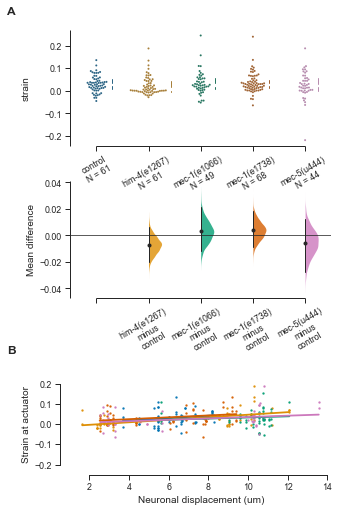

In [64]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(5, 8), #constrained_layout=True,
                        gridspec_kw={'height_ratios':[3, 1], 'hspace':0.7}) 

strain_est_plot_data = dabest.load(central_mito_pair_df, x='genotype', y='strain',
                                   idx=('control', 'him-4(e1267)', 'mec-1(e1066)',
                                        'mec-1(e1738)', 'mec-5(u444)'))
strain_est_plot_data.mean_diff.plot(raw_marker_size=2, es_marker_size=3,
                                    group_summaries_offset=0.1,
                                    group_summaries='median_quartiles',
                                    group_summary_kwargs={'lw':1},
                                    custom_palette=sns.color_palette()[0:5],
                                    ax=axes[0])

labels=axes[0].get_xticklabels()
axes[0].set_xticklabels(labels, rotation=30, horizontalalignment='center')

labels=axes[0].contrast_axes.get_xticklabels()
axes[0].contrast_axes.set_xticklabels(labels, rotation=30, horizontalalignment='center')

position = axes[0].get_position()
position.y0 -= 0.02
axes[0].set_position(position)

for this_strain in worm_strains:
    sns.regplot(x='max_dist', y='strain', ax=axes[1], x_ci=None, ci=None, # hue='genotype',
                scatter_kws={'s':2}, truncate=True,
                data=central_mito_pair_df.loc[central_mito_pair_df['worm_strain'] == this_strain])
axes[1].set_ylim(-0.1, 0.2)
axes[1].set_yticks([-0.2, -0.1, 0, 0.1, 0.2])
sns.despine(ax=axes[1], offset=10, trim=True)

axes[1].set_xlabel('Neuronal displacement (um)')
axes[1].set_ylabel('Strain at actuator')

print(axes[1].get_position())
for ax in fig.axes:
    position = ax.get_position()
    position.x0 += 0.05
    ax.set_position(position)
fig.text(x=0, y=0.92, s='A', weight='bold', va='top')
fig.text(x=0, y=axes[1].get_position().y1+0.05, s='B', weight='bold', va='bottom')
fig.align_ylabels()
fig.savefig(fig_save_dir + 'est_plot_with_strain.pdf')

strain_est_plot_data.mean_diff.statistical_tests

In [65]:
# fig, axes = plt.subplots(3, 2, figsize=(5, 7.5), constrained_layout=True,
#                         gridspec_kw={'width_ratios':[1, 20], 'height_ratios':[1, 2, 1], 'hspace':0.5}) 

# box_ax = axes[1, 1]
# strain_profile_ax = axes[0, 1]
# strain_v_disp_ax = axes[2, 1]

# # Panel Labels
# for letter, ax in zip(['A', 'B', 'C'], range(0,3)):
#     axes[ax, 0].text(0, 1, letter, weight='bold')
#     axes[ax, 0].axis('off')

# strain_profile_ax.set_xlim((-100, 100))
# # axes[1, 1].set_ylim((-.02, 0.0))
# sns.lineplot(x='y', y='strain', ax=strain_profile_ax, hue='worm_strain', ci=None, # style='',
#              data=spatial_strain_df.loc[(spatial_strain_df['pressure']==300) &
#                                         (spatial_strain_df['y'] > -100) &
#                                         (spatial_strain_df['y'] < 100)])
# h, line_plot_labels = strain_profile_ax.get_legend_handles_labels()
# line_plot_labels = [(allele_dict[label]) if label in allele_dict else None for label in line_plot_labels]
# # strain_profile_ax.legend(h, line_plot_labels, frameon=False, loc='upper right', fontsize=8,
# #                  bbox_to_anchor=(1., 1.2), borderaxespad=0.)
# strain_profile_ax.legend().remove()
# rect = mpl.patches.Rectangle((-25,-1), width=50, height=2, facecolor='gray', alpha=0.2)
# strain_profile_ax.add_patch(rect)
# strain_profile_ax.set_xlabel('Distance from center of actuator')
# strain_profile_ax.set_ylabel('Strain')
# strain_profile_ax.set_ylim((strain_profile_ax.get_ylim()[0], 0.075))
# strain_profile_ax.set_yticks([-0.025, 0, 0.025, 0.05, 0.075])
# strain_profile_ax.plot([0, 0],[-1, 1], '--k')

# sns.boxplot(x='genotype', y='strain', data=central_mito_pair_df, ax=box_ax, whis=10, linewidth=0.5)
# sns.swarmplot(x='genotype', y='strain', color=".25", data=central_mito_pair_df, ax=box_ax, size=2)
# # ax.legend(ax.artists, worm_strains)
# # fig.suptitle('TRN stretch at center of actuator')
# box_ax.legend(h, line_plot_labels, frameon=False, loc='lower left', fontsize=8,)
# #                  bbox_to_anchor=(1., 1.2), borderaxespad=0.)
# labels = box_ax.get_xticklabels()
# box_ax.set_xlabel('')
# box_ax.set_ylabel('Strain at actuator')
# # box_ax.set_ylim((-0.1, 0.2))

# for this_strain in worm_strains:
#     sns.regplot(x='max_dist', y='strain', ax=strain_v_disp_ax, x_ci=None, ci=None, # hue='genotype',
#                 scatter_kws={'s':2}, truncate=True,
#                 data=central_mito_pair_df.loc[central_mito_pair_df['worm_strain'] == this_strain])
# # strain_v_disp_ax.set_ylim(-0.1, 0.2)
# strain_v_disp_ax.set_yticks([-0.2, -0.1, 0, 0.1, 0.2])
# sns.despine(offset=10, trim=True)
# box_ax.set_xticklabels(labels, rotation=40, ha='right', va='top')
# strain_v_disp_ax.set_xlabel('Neuronal displacement (um)')
# strain_v_disp_ax.set_ylabel('Strain at actuator')

# fig.savefig(fig_save_dir + 'MutantStrain.pdf')


## Figure 4 - touch tests
### Load data from excel files

In [66]:
mutant_filenames = ['ATT_001_001.xlsx',
                     'ATT_001_002.xlsx',
                     'ATT_001_003.xlsx',
                     'ATT_001_004.xlsx',
                     'ATT_001_005.xlsx']

ctrl_filenames = ['ATT_002_001.xlsx',
                  'ATT_002_002.xlsx',
                  'ATT_002_003.xlsx']

base_folder = pathlib.Path('/Users/adam/Documents/SenseOfTouchResearch/TouchTests')

### Plot touch test results

In [67]:
mutant_results = get_touch_test_df(base_folder, mutant_filenames)
transgenic_results = get_touch_test_df(base_folder, ctrl_filenames)

# fig, axes = plt.subplots(nrows=1, ncols=2, constrained_layout=True, figsize=(4,3),
#                          gridspec_kw={'width_ratios':[2, 5]})

# sns.boxplot(x='genotype', y='touch_outcome', palette=[sns.color_palette()[5],sns.color_palette()[0]],
#             ax=axes[0], data=transgenic_results)
# # sns.swarmplot(x='genotype', y='touch_outcome', color='0.25', size=4,
# #             ax=axes[0], data=ctrl_results)
# axes[0].set_ylabel('Response Probability')
# # labels = ax.get_xticklabels()
# # labels = [allele_dict[strain_name.get_text()] for strain_name in axes[1].get_xticklabels()]
# axes[0].set_ylim(0, 1)
# sns.despine(offset=10, trim=True)
# axes[0].set_xticklabels(['N2', 'jsIs1073'], rotation=40, ha='right')
# axes[0].set_xlabel('');

# # display(ctrl_results.groupby('strain_name').mean()['touch_outcome'])

# axes[1] = sns.boxplot(x='strain_name', y='touch_outcome',
#                       data=mutant_results)
# axes[1].set_ylabel('Response Probability')
# # labels = ax.get_xticklabels()
# labels = [allele_dict[strain_name.get_text()] for strain_name in axes[1].get_xticklabels()]
# sns.despine(offset=10, trim=True)
# axes[1].set_xticklabels(labels, rotation=40, ha='right')
# axes[1].set_xlabel('');

# # mutant_results.groupby('strain_name').mean()['touch_outcome']

# fig.savefig(fig_save_dir + 'touch_tests.eps')

The unpaired mean difference is 0.00667 [95%CI -0.0347, 0.048].
The two-sided p-value of the Mann-Whitney test is 0.983.

5000 bootstrap samples were taken; the confidence interval is bias-corrected and accelerated.
The p-value(s) reported are the likelihood(s) of observing the effect size(s),
if the null hypothesis of zero difference is true.

/Users/adam/anaconda3/envs/spinningDiskAnalysis/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


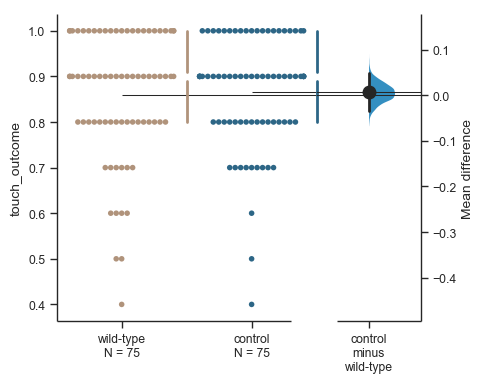

In [68]:
trangenic_est_plot_data = dabest.load(transgenic_results, x='genotype', y='touch_outcome',
                                      idx=('wild-type', 'control'))
fig = trangenic_est_plot_data.mean_diff.plot(raw_marker_size=4, group_summaries='median_quartiles',
    custom_palette=[sns.color_palette()[5], # dabest palette order is weird, so rearrange it
                    sns.color_palette()[0]])
dabest.TwoGroupsEffectSize(
    control=transgenic_results.loc[transgenic_results['genotype']=='wild-type']['touch_outcome'].values,
    test=transgenic_results.loc[transgenic_results['genotype']=='control']['touch_outcome'].values,
    effect_size='mean_diff')

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,control,him-4(e1267),100,100,mean difference,False,-0.215,95,-0.275,-0.163,1.705459e-12,7.553529,1.527417e-12,7.553529,2.685863e-11,7702.0
1,control,mec-1(e1066),100,100,mean difference,False,-0.659,95,-0.698,-0.619,4.781317e-69,32.364008,5.290802e-81,32.364008,1.950796e-34,9955.5
2,control,mec-1(e1738),100,100,mean difference,False,-0.505,95,-0.551,-0.461,2.289699e-53,21.750667,2.220925e-54,21.750667,1.127486e-31,9768.0
3,control,mec-5(u444),100,100,mean difference,False,-0.534,95,-0.580,-0.487,9.461455e-56,22.458122,2.421653e-56,22.458122,7.476523e-32,9783.0


/Users/adam/anaconda3/envs/spinningDiskAnalysis/lib/python3.6/site-packages/matplotlib/figure.py:2366: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


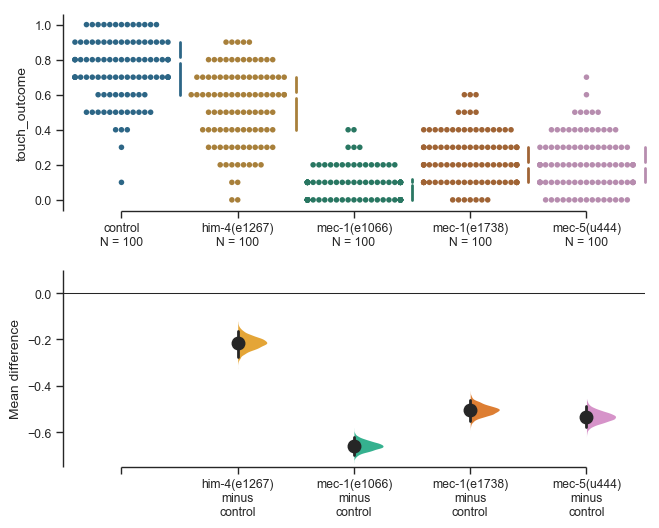

In [69]:
mutant_est_plot_data = dabest.load(mutant_results, x='genotype', y='touch_outcome',
                            idx=('control', 'him-4(e1267)', 'mec-1(e1066)','mec-1(e1738)', 'mec-5(u444)'))
fig = mutant_est_plot_data.mean_diff.plot(
    contrast_ylim=(-0.75,0.1), raw_marker_size=4, group_summaries='median_quartiles',
    custom_palette=[sns.color_palette()[1], # dabest palette order is weird, so rearrange it
                    sns.color_palette()[2],
                    sns.color_palette()[3],
                    sns.color_palette()[4],
                    sns.color_palette()[0]])
mutant_est_plot_data.mean_diff.statistical_tests

In [70]:
mutant_results.groupby('genotype').mean()['touch_outcome']

genotype
control         0.742
him-4(e1267)    0.527
mec-1(e1066)    0.083
mec-1(e1738)    0.237
mec-5(u444)     0.208
Name: touch_outcome, dtype: float64

### Statistical tests

In [71]:
touch_test_data = []
for this_worm_strain in worm_strains:
    touch_test_data.append(mutant_results.loc[
        mutant_results['strain_name'] == this_worm_strain]['touch_outcome'])
print(stats.f_oneway(*touch_test_data))

mc = multicomp.MultiComparison(
    mutant_results['touch_outcome'], mutant_results['genotype'],
    group_order=[allele_dict[strain] for strain in worm_strains if strain is not 'N2'])
mc_results = mc.tukeyhsd()
print(mc_results)

F_onewayResult(statistic=nan, pvalue=nan)
      Multiple Comparison of Means - Tukey HSD, FWER=0.05       
   group1       group2    meandiff p-adj   lower   upper  reject
----------------------------------------------------------------
     control him-4(e1267)   -0.215  0.001 -0.2785 -0.1515   True
     control mec-1(e1066)   -0.659  0.001 -0.7225 -0.5955   True
     control mec-1(e1738)   -0.505  0.001 -0.5685 -0.4415   True
     control  mec-5(u444)   -0.534  0.001 -0.5975 -0.4705   True
him-4(e1267) mec-1(e1066)   -0.444  0.001 -0.5075 -0.3805   True
him-4(e1267) mec-1(e1738)    -0.29  0.001 -0.3535 -0.2265   True
him-4(e1267)  mec-5(u444)   -0.319  0.001 -0.3825 -0.2555   True
mec-1(e1066) mec-1(e1738)    0.154  0.001  0.0905  0.2175   True
mec-1(e1066)  mec-5(u444)    0.125  0.001  0.0615  0.1885   True
mec-1(e1738)  mec-5(u444)   -0.029 0.6963 -0.0925  0.0345  False
----------------------------------------------------------------


/Users/adam/anaconda3/envs/spinningDiskAnalysis/lib/python3.6/site-packages/scipy/stats/stats.py:2951: RuntimeWarning: invalid value encountered in double_scalars
  ssbn += _square_of_sums(a - offset) / len(a)


In [72]:
N2_response_probabilities = transgenic_results.loc[
        transgenic_results['strain_name'] == 'N2']['touch_outcome']
NM3573_response_probabilities = transgenic_results.loc[
        transgenic_results['strain_name'] == 'NM3573']['touch_outcome']
ttest_results = stats.ttest_ind(N2_response_probabilities.values, NM3573_response_probabilities.values)

print('N2', N2_response_probabilities.mean())
print('NM3573', NM3573_response_probabilities.mean())
print(ttest_results)


N2 0.8586666666666667
NM3573 0.8653333333333334
Ttest_indResult(statistic=-0.30970075601227726, pvalue=0.7572241516056211)


## Supplemental Figures

### Number of frames per trials

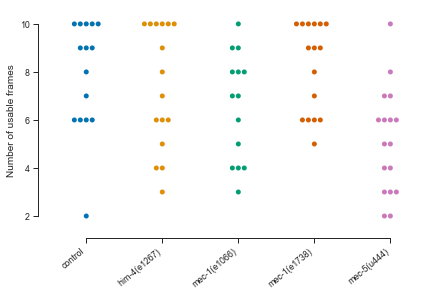

In [73]:
fig, ax = plt.subplots(constrained_layout=True)

sns.swarmplot(x='genotype', y='frame', ax=ax,
              data=linked_mitos_df.groupby('Experiment_id', as_index=False).max())
ax.set_ylabel('Number of usable frames')
ax.xaxis.label.set_visible(False)
xlabels = ax.get_xticklabels()
sns.despine(offset=10, trim=True)
ax.set_xticklabels(xlabels, rotation=40, ha='right');

# fig = ax.get_figure()
fig.savefig(fig_save_dir + 'NumFramesPerTrial.eps')

### Number of mitos and distances between mitos comparisons

genotype
control         8.866667
him-4(e1267)    9.062500
mec-1(e1066)    8.857143
mec-1(e1738)    8.875000
mec-5(u444)     7.176471
Name: particle, dtype: float64

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,control,him-4(e1267),15,16,mean difference,False,0.195833,95,-1.475000,1.645833,0.810280,-0.242410,0.808979,-0.243961,0.630352,107.5
1,control,mec-1(e1066),15,14,mean difference,False,-0.009524,95,-1.742857,1.452381,0.990742,0.011715,0.990818,0.011615,1.000000,104.5
2,control,mec-1(e1738),15,16,mean difference,False,0.008333,95,-1.604167,1.516667,0.991916,-0.010224,0.991867,-0.010282,0.951574,118.0
3,control,mec-5(u444),15,17,mean difference,False,-1.690196,95,-3.298039,-0.298039,0.042260,2.132154,0.038780,2.161291,0.048452,179.5


Min:


genotype
control         5.003019
him-4(e1267)    4.951283
mec-1(e1066)    4.690472
mec-1(e1738)    5.092111
mec-5(u444)     5.418538
Name: distance, dtype: float64

Mean:


genotype
control         25.959381
him-4(e1267)    27.700374
mec-1(e1066)    27.199843
mec-1(e1738)    26.648748
mec-5(u444)     30.930987
Name: distance, dtype: float64

Max:


genotype
control         64.380281
him-4(e1267)    76.101376
mec-1(e1066)    67.312651
mec-1(e1738)    64.123921
mec-5(u444)     84.800146
Name: distance, dtype: float64

,control,test,control_N,test_N,effect_size,is_paired,difference,ci,bca_low,bca_high,pvalue_welch,statistic_welch,pvalue_students_t,statistic_students_t,pvalue_mann_whitney,statistic_mann_whitney
0,control,him-4(e1267),1046,1090,mean difference,False,1.740992,95,0.640747,2.864595,2.657172e-03,-3.008382,2.661993e-03,-3.007825,5.258012e-03,530303.0
1,control,mec-1(e1066),1046,840,mean difference,False,1.240462,95,-0.069686,2.511456,5.880754e-02,-1.890897,5.590889e-02,-1.912927,1.747064e-01,423366.0
2,control,mec-1(e1738),1046,1137,mean difference,False,0.689366,95,-0.452879,1.802407,2.236165e-01,-1.217317,2.233295e-01,-1.218069,1.959536e-01,575625.0
3,control,mec-5(u444),1046,618,mean difference,False,4.971606,95,3.455586,6.511115,6.681301e-11,-6.591086,8.672608e-12,-6.876161,5.570799e-09,268008.0


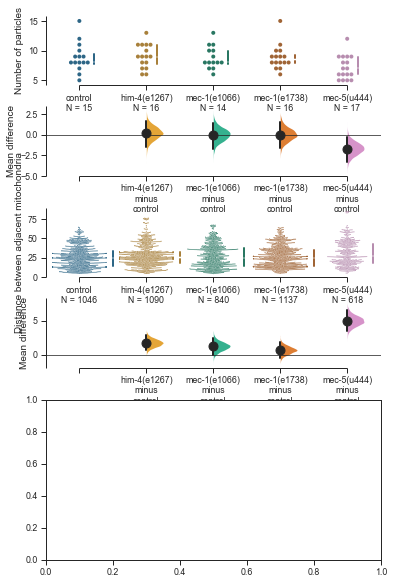

In [74]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(6, 10))

particle_count_df = linked_mitos_df.loc[
    linked_mitos_df['frame'] == 0].groupby(
    ['Experiment_id', 'genotype'], as_index=False).count()

num_mitos_in_trial = dabest.load(particle_count_df, x='genotype', y='particle',
                            idx=('control', 'him-4(e1267)', 'mec-1(e1066)','mec-1(e1738)', 'mec-5(u444)'))
fig = num_mitos_in_trial.mean_diff.plot(
    raw_marker_size=4, group_summaries='median_quartiles', #contrast_ylim=(-0.75,0.1),
    custom_palette=sns.color_palette(),
    ax=axes[0])

fig.axes[0].set_ylabel('Number of particles')
# fig.savefig(fig_save_dir + 'mitos_per_trial_by_genotype.eps')
display(particle_count_df.groupby('genotype').mean()['particle'])
display(num_mitos_in_trial.mean_diff.statistical_tests)

mito_distances = dabest.load(mito_pair_df, x='genotype', y='distance',
                            idx=('control', 'him-4(e1267)', 'mec-1(e1066)','mec-1(e1738)', 'mec-5(u444)'))
fig = mito_distances.mean_diff.plot(
    raw_marker_size=1, group_summaries='median_quartiles',
    custom_palette=sns.color_palette(),
    ax=axes[1])

fig.axes[1].set_ylabel('Distance between adjacent mitochondria')
# fig.savefig(fig_save_dir + 'mito_distances.eps')
print('Min:')
display(mito_pair_df.groupby('genotype').min()['distance'])
print('Mean:')
display(mito_pair_df.groupby('genotype').mean()['distance'])
print('Max:')
display(mito_pair_df.groupby('genotype').max()['distance'])
display(mito_distances.mean_diff.statistical_tests)

## Sanity checks to make sure calculations didn't go horribly wrong
### Rest distances actually match previous particle locations

In [75]:
test_start = time.time()

stimulus_off_mitos = linked_mitos_df.loc[linked_mitos_df['pressure'] == 0]
pd.testing.assert_series_equal(stimulus_off_mitos['y'], stimulus_off_mitos['y_rest'], check_names=False)

for index, row in linked_mitos_df.iterrows():
    if row['pressure'] == 0:
        assert row['y_rest'] == row['y']
    else:
        current_y = row['y_rest']
        previous_y = linked_mitos_df.loc[
            (linked_mitos_df['Experiment_id'] == row['Experiment_id']) &
            (linked_mitos_df['frame'] == row['frame'] - 1) & 
            (linked_mitos_df['particle'] == row['particle'])]['y'].values[0]
        assert current_y == previous_y

### Rest distances actually match previous particle locations when looking at uncertainty in measurement

### Dataframes with mito pairs pressure off/on are different

In [76]:
try:
    pd.testing.assert_frame_equal(
        mito_pairs_pressure_off.reset_index(drop=True),
        mito_pair_df.loc[mito_pair_df['pressure'] == 0].reset_index(drop=True), check_names=False)
except:
    # we should get here, since the dataframes should be different
    pass
else:
    raise AssertionError

### Displacements  and distances calculated correctly
For each dimension, check:
- Calculated displacements are the difference between the current position and the rest position
- Distances are the absolution value of displacements
- Some displacements are negative

In [77]:
for dim in ['x', 'y', 'z']:
    pd.testing.assert_series_equal(linked_mitos_df[dim + '_disp'],
                                   linked_mitos_df[dim] - linked_mitos_df[dim + '_rest'],
                                   check_names=False)
    pd.testing.assert_series_equal(linked_mitos_df[dim + '_dist'],
                                   linked_mitos_df[dim + '_disp'].abs(),
                                   check_names=False)
    try:
        pd.testing.assert_series_equal(linked_mitos_df[dim + '_disp'],
                                       linked_mitos_df[dim + '_disp'].abs(),
                                       check_names=False)
    except AssertionError:
        pass
    else:
        raise AssertionError('Some displacements should be negative')
    print('tested', dim, 'dimesion displacements.')


tested x dimesion displacements.
tested y dimesion displacements.
tested z dimesion displacements.


### Distances in multiple dimensions are vector sum of individual displacements

In [78]:
pd.testing.assert_series_equal(linked_mitos_df['xyz_dist'],
                              (linked_mitos_df[['x_dist', 'y_dist', 'z_dist']]**2).sum(axis=1)**0.5,
                              check_names=False)
pd.testing.assert_series_equal(linked_mitos_df['xz_dist'],
                              (linked_mitos_df[['x_dist', 'z_dist']]**2).sum(axis=1)**0.5,
                              check_names=False)

### Mitochondria pairs are correct


#### correct number of pairs for each trial

In [79]:
linked_mitos_grouped = linked_mitos_df.groupby(['Experiment_id', 'frame'])
paired_mitos_grouped = mito_pair_df.groupby(['Experiment_id', 'frame'])
pd.testing.assert_series_equal(linked_mitos_grouped['particle'].nunique() - 1,
                               paired_mitos_grouped['pair_id'].nunique(),
                               check_names=False)

- pair distance is correct using original particle locations
- pairs are in correct order
- distance calculation
- rest distances while we're at it
- stretch calculation
- strain calculation

In [80]:
for index, row in mito_pair_df.iterrows():
    p1_coords = linked_mitos_df.loc[
        (linked_mitos_df['Experiment_id'] == row['Experiment_id']) &
        (linked_mitos_df['frame'] == row['frame']) &
        (linked_mitos_df['particle'] == row['particle_1'])][['x','y','z']]
    p2_coords = linked_mitos_df.loc[
        (linked_mitos_df['Experiment_id'] == row['Experiment_id']) &
        (linked_mitos_df['frame'] == row['frame']) &
        (linked_mitos_df['particle'] == row['particle_2'])][['x','y','z']]
    this_dist = (p1_coords.subtract(p2_coords.values)**2).sum(axis=1)**0.5
    
    assert row['particle_1_yval'] == p1_coords['y'].values
    assert row['particle_2_yval'] == p2_coords['y'].values
    assert row['particle_1_yval'] < row['particle_2_yval']
    assert row['distance'] == this_dist.values
    
    # Rest distance
    if row['pressure'] == 0:
        assert row['rest_dist'] == row['distance']
    else:
        current_dist = row['rest_dist']
        previous_dist = mito_pair_df.loc[
            (mito_pair_df['Experiment_id'] == row['Experiment_id']) &
            (mito_pair_df['frame'] == row['frame'] - 1) & 
            (mito_pair_df['pair_id'] == row['pair_id'])]['distance'].values[0]
        assert current_dist == previous_dist
    
    assert row['stretch'] == row['distance'] - row['rest_dist']
    assert row['strain'] == row['stretch'] / row['rest_dist']

#### pressure values are maintained properly

In [81]:
for index, row in linked_mitos_df.iterrows():
    assert row['pressure'] == metadata_df.loc[
        metadata_df['Experiment_id']==row['Experiment_id']][
        'pressure_kPa'].values[0][row['frame']]
for index, row in mito_pair_df.iterrows():
    assert row['pressure'] == metadata_df.loc[
        metadata_df['Experiment_id']==row['Experiment_id']][
        'pressure_kPa'].values[0][row['frame']]
# for index, row in spatial_strain_df.iterrows():
#     assert row['pressure'] == metadata_df.loc[
#         metadata_df['Experiment_id']==row['Experiment_id']][
#         'pressure_kPa'].values[0][row['frame']]

## Coordinates for spatial average of strain are correct

In [82]:
print('Testing took', str(round(time.time()-test_start)), 'seconds.')
print('Notebook took', str(round((time.time()-start) / 60, 1)), 'minutes to run.')

Testing took 82 seconds.
Notebook took 13.3 minutes to run.
